In [35]:
"""
In this example we demonstrate how to implement a DQN agent and
train it to trade optimally on a periodic price signal.
Training time is short and results are unstable.
Do not hesitate to run several times and/or tweak parameters to get better results.
Inspired from https://github.com/keon/deep-q-learning
"""
import random

import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from tgym.envs import SpreadTrading
%matplotlib inline


In [33]:
class DQNAgent:
    def __init__(self,
                 state_size,
                 action_size,
                 episodes,
                 episode_length,
                 memory_size=2000,
                 train_interval=100,
                 gamma=0.95,
                 learning_rate=0.001,
                 batch_size=64,
                 epsilon_min=0.01
                 ):
        self.state_size = state_size
        self.action_size = action_size
        self.memory_size = memory_size
        self.memory = [None] * memory_size
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_min = epsilon_min
        self.epsilon_decrement = (self.epsilon - epsilon_min)\
            * train_interval / (episodes * episode_length)  # linear decrease rate
        self.learning_rate = learning_rate
        self.train_interval = train_interval
        self.batch_size = batch_size
        self.brain = self._build_brain()
        self.i = 0

    def _build_brain(self):
        """Build the agent's brain
        """
        brain = Sequential()
        neurons_per_layer = 24
        activation = "relu"
        brain.add(Dense(neurons_per_layer,
                        input_dim=self.state_size,
                        activation=activation))
        brain.add(Dense(neurons_per_layer, activation=activation))
        brain.add(Dense(self.action_size, activation='linear'))
        brain.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return brain

    def act(self, state):
        """Acting Policy of the DQNAgent
        """
        action = np.zeros(self.action_size)
        if np.random.rand() <= self.epsilon:
            action[random.randrange(self.action_size)] = 1
        else:
            state = state.reshape(1, self.state_size)
            act_values = self.brain.predict(state)
            action[np.argmax(act_values[0])] = 1
        return action

    def observe(self, state, action, reward, next_state, done, warming_up=False):
        """Memory Management and training of the agent
        """
        self.i = (self.i + 1) % self.memory_size
        self.memory[self.i] = (state, action, reward, next_state, done)
        if (not warming_up) and (self.i % self.train_interval) == 0:
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrement
            state, action, reward, next_state, done = self._get_batches()
            reward += (self.gamma
                       * np.logical_not(done)
                       * np.amax(self.brain.predict(next_state),
                                 axis=1))
            q_target = self.brain.predict(state)
            print "state: ", state[0]
            print "action[0]: ", action[0]
            print "action[1]: ", action[1]
            print "q_target: ", q_target[action[0], action[1]]
            print "reward: ", reward
            
            q_target[action[0], action[1]] = reward
            return self.brain.fit(state, q_target,
                                  batch_size=self.batch_size,
                                  epochs=1,
                                  verbose=False)

    def _get_batches(self):
        """Selecting a batch of memory
           Split it into categorical subbatches
           Process action_batch into a position vector
        """
        batch = np.array(random.sample(self.memory, self.batch_size))
        state_batch = np.concatenate(batch[:, 0])\
            .reshape(self.batch_size, self.state_size)
        action_batch = np.concatenate(batch[:, 1])\
            .reshape(self.batch_size, self.action_size)
        reward_batch = batch[:, 2]
        next_state_batch = np.concatenate(batch[:, 3])\
            .reshape(self.batch_size, self.state_size)
        done_batch = batch[:, 4]
        # action processing
        action_batch = np.where(action_batch == 1)
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

In [36]:
import matplotlib.pyplot as plt
from tgym.envs import SpreadTrading
from tgym.gens.deterministic import WavySignal
# Instantiating the environmnent
generator = WavySignal(period_1=25, period_2=50, epsilon=-0.5)
episodes = 50
episode_length = 400
trading_fee = .2
time_fee = 0
history_length = 2
environment = SpreadTrading(spread_coefficients=[1],
                                data_generator=generator,
                                trading_fee=trading_fee,
                                time_fee=time_fee,
                                history_length=history_length)

In [37]:
environment.__dict__

{'_action': array([1, 0, 0]),
 '_data_generator': <tgym.gens.deterministic.WavySignal at 0x122273590>,
 '_entry_price': 0,
 '_exit_price': 0,
 '_first_render': True,
 '_game_length': 1000,
 '_history_length': 2,
 '_iteration': 0,
 '_position': array([1, 0, 0]),
 '_price_range': 0,
 '_prices_history': [(0.31036821396513004, 0.31036821396513004),
  (0.5982855675701456, 0.5982855675701456)],
 '_spread_coefficients': [1],
 '_time_fee': 0,
 '_total_pnl': 0,
 '_total_reward': 0,
 '_trading_fee': 0.2,
 'n_actions': 3,
 'state_shape': (8,)}

In [34]:
state = environment.reset()
# Instantiating the agent
memory_size = 3000
state_size = len(state)
gamma = 0.96
epsilon_min = 0.01
batch_size = 64
action_size = len(SpreadTrading._actions)
train_interval = 10
learning_rate = 0.001
agent = DQNAgent(state_size=state_size,
                     action_size=action_size,
                     memory_size=memory_size,
                     episodes=episodes,
                     episode_length=episode_length,
                     train_interval=train_interval,
                     gamma=gamma,
                     learning_rate=learning_rate,
                     batch_size=batch_size,
                     epsilon_min=epsilon_min)
# Warming up the agent
for _ in range(memory_size):
        action = agent.act(state)
        next_state, reward, done, _ = environment.step(action)
        agent.observe(state, action, reward, next_state, done, warming_up=True)
# Training the agent
for ep in range(episodes):
    state = environment.reset()
    rew = 0
    for _ in range(episode_length):
        action = agent.act(state)
        next_state, reward, done, _ = environment.step(action)
        loss = agent.observe(state, action, reward, next_state, done)
        state = next_state
        rew += reward
    print("Ep:" + str(ep)
           + "| rew:" + str(round(rew, 2))
           + "| eps:" + str(round(agent.epsilon, 2))
           + "| loss:" + str(round(loss.history["loss"][0], 4)))

state:  [0.31036821 0.31036821 0.59828557 0.59828557 0.         1.
 0.         0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 0 2 0 1 2 1 1 0 1 2 1 2 0 2 0 0 0 0 0 2 2 0 0 2 1 1 2 2 1 1 0 0 1 0 1 2
 2 2 2 2 1 0 2 1 0 2 0 0 2 1 0 2 2 1 0 2 0 0 2 0 1 0 1]
q_target:  [ 0.21130309 -0.07664768  0.21130309 -0.07664768  0.04777093  0.21130309
  0.04777093  0.04777093 -0.07664768  0.04777093  0.21130309  0.04777093
  0.21130309 -0.07664768  0.21130309 -0.07664768 -0.07664768 -0.07664768
 -0.07664768 -0.07664768  0.21130309  0.21130309 -0.07664768 -0.07664768
  0.21130309  0.04777093  0.04777093  0.21130309  0.21130309  0.04777093
  0.04777093 -0.07664768 -0.07664768  0.04777093 -0.07664768  0.04777093
  0.21130309  0.21130309  0.21130309  0.21130309  0.21130309  0.04777093
 -0.07664768  0.21130309  0.04777093

state:  [0.31036821 0.31036821 0.59828557 0.59828557 0.         1.
 0.         0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 1 1 1 2 2 2 1 0 2 2 0 2 1 0 0 1 0 1 2 2 1 2 2 0 2 2 0 2 0 2 1 0 1 2 1 2
 2 2 0 0 0 0 2 0 2 1 0 1 2 1 0 2 1 1 0 2 0 1 1 2 2 0 2]
q_target:  [-0.08119541  0.0612645   0.0612645   0.0612645  -0.08119541 -0.08119541
 -0.08119541  0.0612645   0.23791525 -0.08119541 -0.08119541  0.23791525
 -0.08119541  0.45456624  0.23791525  0.23791525  0.0612645   0.23791525
  0.0612645  -0.08119541 -0.08119541  0.0612645  -0.08119541 -0.08119541
  0.23791525 -0.08119541 -0.08119541  0.23791525 -0.08119541  0.23791525
 -0.08119541  0.0612645   0.23791525  0.0612645  -0.08119541  0.0612645
 -0.08119541 -0.08119541 -0.08119541  0.23791525  0.23791525  0.23791525
  0.23791525 -0.08119541 -0.44122562 

state:  [-0.40614962 -0.40614962 -0.70335634 -0.70335634  0.31101351  0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [1 1 0 0 1 1 1 2 2 2 2 1 1 0 0 2 0 1 1 1 1 0 2 1 1 2 1 1 2 0 0 2 2 0 2 0 2
 1 1 1 0 2 0 1 0 2 2 0 2 2 1 0 2 2 1 2 0 1 0 1 0 1 0 0]
q_target:  [ 0.65848583  0.03251764  0.16476797  0.16476797  0.03251764  0.03251764
  0.03251764 -0.10157708  0.19487372 -0.10157708 -0.10157708  0.03251764
  0.03251764  0.16476797  0.16476797 -0.10157708  0.16476797  0.03251764
  0.03251764  0.03251764  0.03251764  0.16476797 -0.10157708  0.29328343
  0.54656786 -0.10157708  0.03251764  0.03251764 -0.10157708  0.16476797
  0.16476797 -0.10157708 -0.10157708  0.16476797 -0.10157708  0.16476797
 -0.10157708  0.03251764  0.03251764  0.03251764  0.16476797  0.06638428
  0.16476797  0.03251764  0.

 -0.005344352722167989 0.008868908882141091 -0.9240539360362674 0.0]
state:  [0.31036821 0.31036821 0.59828557 0.59828557 0.         1.
 0.         0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 0 0 2 1 0 0 0 2 2 2 0 2 0 1 0 0 2 1 1 1 2 0 0 1 1 2 0 0 1 0 1 0 2 0 2 2
 1 0 2 2 0 1 0 1 2 2 1 0 2 1 2 2 2 2 1 1 0 1 0 0 2 1 1]
q_target:  [-6.8001360e-02  6.3852698e-02  9.0188682e-02 -6.8001360e-02
  2.0257555e-01  9.0188682e-02  9.0188682e-02  9.0188682e-02
 -6.8001360e-02 -6.8001360e-02  1.8528455e-01 -9.5920071e-02
 -6.8001360e-02  9.0188682e-02 -1.3549701e-02  9.0188682e-02
  1.6914196e-01  2.8397650e-01  4.1130825e-04 -1.3549701e-02
 -1.3549701e-02  2.0735890e-01 -2.5723252e-02  9.0188682e-02
 -1.3549701e-02  1.1561129e+00 -6.8001360e-02  9.0188682e-02
  2.3661780e-01 -1.3549701e-02  9.0188682e-02 -1.35

state:  [1.21088294 1.21088294 1.50736873 1.50736873 1.21088294 0.
 0.         1.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 1 2 2 0 2 2 0 2 2 2 0 2 1 0 0 0 0 1 2 2 2 2 2 1 1 2 1 0 2 0 2 2 0 0 0 1
 2 0 1 2 1 0 2 2 2 2 0 2 0 0 2 1 2 1 0 2 2 0 0 1 1 0 2]
q_target:  [-0.20618775  0.7207328  -0.14296956 -0.14296956  0.07223273 -0.14296956
  0.7847555   0.07223273 -0.14296956 -0.14296956 -0.14296956  0.07223273
 -0.14296956 -0.0912576   0.07223273  0.07223273  0.07223273  0.07223273
 -0.0912576  -0.14296956 -0.14296956 -0.14296956 -0.10072566 -0.14296956
 -0.0912576  -0.0912576   0.5090026  -0.19823381  0.11629052 -0.14296956
  0.07223273 -0.14296956 -0.14296956  0.07223273  0.07223273  0.07223273
 -0.0912576  -0.1468134   0.07223273 -0.0912576   0.08122147 -0.0912576
  0.07223273  0.43081033 -0.14296956 

state:  [0.31036821 0.31036821 0.59828557 0.59828557 0.         1.
 0.         0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [1 1 1 2 2 0 1 1 0 1 2 2 1 0 0 1 2 0 0 0 0 1 2 1 0 2 2 1 2 2 2 0 2 0 0 0 2
 2 2 2 2 0 1 0 0 2 1 0 1 1 0 0 0 0 2 0 1 2 2 1 0 0 2 1]
q_target:  [-0.12172098  1.0472484   0.82491827 -0.11260284  0.16684963  0.01653254
 -0.12172098 -0.12172098  0.01653254 -0.12172098 -0.11260284  0.09726945
 -0.12172098  0.09418614  0.01653254 -0.12172098 -0.11260284  0.01653254
  0.41619468  0.01653254  0.30492553 -0.12172098 -0.11260284 -0.12172098
  0.01653254  0.66888535 -0.11260284 -0.12172098 -0.11260284 -0.11260284
 -0.11260284  0.01653254 -0.11260284  0.01653254  0.6827174   0.01653254
 -0.11260284  0.32309377 -0.11260284 -0.11260284  0.93564147  0.01653254
 -0.12172098  0.8472108   0.01653254

q_target:  [-0.17990139  0.02933195 -0.17990139  0.6405314  -0.158577    0.02933195
  0.02933195  0.09138871  0.8619151  -0.17990139  0.02933195 -0.17990139
 -0.158577   -0.17990139  0.02933195  0.07502526  0.58185154  0.02933195
 -0.17990139  0.7037412   0.02933195  0.07534255  0.58185154 -0.17990139
 -0.158577    1.6267306   0.24602187 -0.17990139  0.1185889   0.02933195
 -0.158577    0.02933195 -0.17990139 -0.17990139  1.0713754   0.04473738
  0.12525588  0.2899981   0.02933195  0.02933195  0.30634394  0.02933195
  0.05388872 -0.158577   -0.17990139  0.9088762   0.2627593  -0.158577
 -0.158577    0.6521069   1.0093303  -0.158577   -0.158577    0.02933195
  0.02933195  0.97048956  0.5179398  -0.02428636  0.02933195  0.12318272
 -0.04427611  0.02933195 -0.158577    0.41523033]
reward:  [-0.5632712640026294 0.0 -0.2 0.7805180740356445 -0.2 0.0 0.0
 0.8029290771484374 0.920179987491333 -0.2 0.0 -0.2 -0.13340771502707588
 -0.2 0.0 -0.40770758817074937 0.52897891998291 0.0 -0.2
 0.6054814

state:  [-0.84275838 -0.84275838 -0.59828557 -0.59828557  0.          1.
  0.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 1 1 1 0 2 0 1 0 0 2 1 1 0 2 0 0 0 1 2 2 1 2 0 2 1 2 2 2 1 2 0 0 1 2 1 0
 0 1 1 2 1 2 0 1 0 0 1 2 2 1 0 2 1 2 0 0 2 1 0 1 0 1 2]
q_target:  [ 0.33434737 -0.12654927 -0.12654927 -0.12654927  0.01073564  0.3410389
  0.6614301  -0.12654927  1.5102026  -0.13347349  0.17600381  0.97706825
 -0.12654927  1.0399232  -0.10253754  1.8150841   1.0282867   0.15607528
  0.85950315  0.46031126 -0.03476974 -0.12654927 -0.10253754  0.01073564
 -0.10253754  1.218298    0.24055475  0.10279897  0.7061435   0.18142274
 -0.10253754  0.9334886   0.63243157 -0.12654927 -0.10253754  0.22017303
  0.01073564  0.10963626 -0.12654927  0.66062856 -0.10253754 -0.12654927
  0.11805363  0.01073564 -0.1

q_target:  [ 0.6955155  -0.03269659  0.4974466  -0.08259055  0.0019664   0.06286789
  0.7418804  -0.08259055  0.97469455  0.17429471  0.9923394   0.4359107
  1.7068832   1.0345463   0.8440645  -0.038019   -0.03269659 -0.03269659
 -0.03269659 -0.03269659  0.12970635 -0.03269659  0.7619909   1.8255321
  0.3312912   0.18574512 -0.08259055  0.06286789  0.1093311   0.06286789
  0.6396917   0.8037236   0.06286789 -0.19009659 -0.08259055  0.20478484
  0.23980021  0.757753   -0.08259055 -0.08259055  0.7121273   0.40039694
  0.06286789  0.06286789 -0.03269659  0.06286789  0.10590187 -0.03269659
  0.42954522 -0.08259055  1.131619   -0.03269659  0.33133063  0.83834714
 -0.03269659  0.24217907 -0.2555611   1.243684   -0.03269659 -0.08259055
  1.0211463   0.28982744 -0.08259055  0.06286789]
reward:  [0.43816419741168194 -0.2 0.44332246780395507 0.8143698517983946
 -0.20941066712141038 0.0 0.9612503814697265 -0.2 0.9989489364624023
 0.26389586448669433 1.0067238235473632 0.8160698699951172
 1.818438

state:  [-0.84697545 -0.84697545 -0.43570145 -0.43570145 -0.84697545  0.
  0.          1.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 1 2 2 0 2 2 2 2 0 0 1 1 0 2 1 1 0 2 2 1 1 2 0 0 2 2 1 0 0 2 1 1 2 0 0 0
 0 2 0 0 0 1 0 2 0 1 2 2 1 0 0 2 0 1 1 1 1 0 2 1 0 2 0]
q_target:  [ 0.16451372  0.67944133  0.03819823  0.01485793  0.09721276  0.3128143
  0.5187801   1.254668    0.42926365  1.4796312   0.63835603  0.6054449
  1.0058771   1.3318894   0.03819823 -0.02796443 -0.02796443  0.8012847
  1.0692244   0.4497795   0.7788687  -0.02796443  0.3415978   0.09721276
  0.09721276  0.03819823  1.151316    0.13921928  0.7029031   1.0874932
  0.03819823  2.054184    0.3572502   0.8592168   0.09721276  1.7937603
  1.5435171   1.2826414   0.03819823  0.41512862  0.09721276  0.09721276
 -0.02796443  0.09721276  0.02768

state:  [0.31036821 0.31036821 0.59828557 0.59828557 0.         1.
 0.         0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 0 1 0 0 0 0 0 0 0 1 0 1 2 2 1 0 1 0 1 1 2 2 2 0 1 2 2 2 1 1 2 2 0 2 2 2
 0 2 2 2 2 2 2 1 0 2 2 0 0 0 1 0 0 2 2 1 1 2 2 1 2 2 0]
q_target:  [ 1.6718568e-01  1.6326681e-01  6.0305804e-01  5.7502723e-01
  1.2213057e-02  2.3135023e+00  5.4327494e-01  4.7834698e-02
  4.3093005e-01  1.6326681e-01  3.8492885e-01  1.0490569e+00
  2.2758913e-01  1.4930402e+00  4.2253956e-01  9.8951423e-01
  5.5147147e-01  6.9287193e-01  1.6326681e-01 -1.1636203e-01
  1.3335776e-01  1.1522778e+00  3.9065951e-01  2.7738240e-02
  1.6326681e-01  1.3335776e-01  1.4173412e+00  1.3318292e+00
  3.0729231e-01  5.8477569e-01  1.0817320e+00  8.1355685e-01
  2.6034662e-01  6.1858982e-01  1.8063177e+00  1.6718568e-0

state:  [0.31036821 0.31036821 0.59828557 0.59828557 0.         1.
 0.         0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [1 1 1 0 1 2 2 2 0 1 0 1 2 2 0 0 1 0 2 0 0 0 2 2 0 1 2 2 1 2 2 0 1 0 1 0 0
 1 0 0 2 2 2 2 2 1 0 0 1 2 1 0 1 2 2 0 0 1 2 1 1 1 2 0]
q_target:  [ 0.36304235  1.3618492   0.78563136  0.7482532   1.3090745   1.7380997
  0.17041716  1.1844337   0.33656943  0.3738603   2.168023    0.17279135
  2.3467112   1.583873    2.3140302   2.7295024   0.09516238  1.416693
 -0.08457173  0.33656943  0.45587075  2.8067307   0.18860145  1.7380997
  1.9527001   0.36304235  0.01474855  0.06055335  2.6908822   0.35805547
  0.14233743  1.8766636   0.50993437  0.35436222  0.81735104  1.7883539
  1.8888191   0.56833667  0.33656943  1.8972067   0.28615984  0.18860145
  0.2728592   0.10868407  0.337566    2.4

state:  [-1.83931365 -1.83931365 -1.7204774  -1.7204774   0.          1.
  0.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 1 2 2 2 1 2 0 0 0 1 1 1 2 1 0 1 2 2 1 2 0 2 2 2 2 1 0 2 2 0 1 2 1 2 0 1
 1 0 0 2 1 0 2 1 1 2 0 0 0 1 1 1 2 0 0 0 0 1 0 0 1 0 0]
q_target:  [-9.2314705e-02  6.6473916e-02  2.4679618e+00 -1.0260050e-01
  3.1476659e-01  2.7527878e+00 -2.4763952e-01  1.6138195e+00
 -4.0869344e-02  4.9550423e-01  2.5409539e+00  1.2392911e+00
  1.2723601e+00  1.2047887e+00  1.6709690e+00  5.9602523e-01
  1.3023598e-01  1.8802413e+00  1.3716038e-01  2.3906467e+00
  1.9110645e+00  2.9210469e-01  1.5198835e+00  1.3158058e-01
 -3.8580474e-02 -7.5717643e-04  2.2739100e+00  3.1464162e-01
 -4.5411933e-02  1.3035898e+00  1.4232140e+00  4.2402506e-01
  7.6318666e-02  3.8596219e-01  1.9947570e-02  5.60

state:  [0.93507662 0.93507662 0.70335634 0.70335634 0.93507662 0.
 1.         0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 2 0 0 0 0 0 1 0 1 0 2 0 0 2 2 1 0 1 1 0 2 1 1 0 2 2 1 0 0 1 1 0 1 1 1 2
 0 1 2 2 0 0 1 1 0 0 0 2 0 0 0 2 0 0 1 0 2 2 2 1 1 0 1]
q_target:  [ 1.3382088   2.5805452   0.2790109   0.49409002  1.7949294   3.0087395
  1.7564937   0.2983918   1.7564937   3.3856692   0.48817396  2.7081647
  1.0809479   1.8086023   0.02316346  1.9027145   0.6599083   2.1911776
  1.6679711   0.79121965  2.2113543  -0.05696676  0.44148442  0.8694911
  1.3180815   1.5545096   2.9684162  -0.42133692  0.40498558  0.48817396
  1.2097427   0.8694911   3.0685618   2.0996885   2.8281543   1.4747556
  0.66229045  0.3378223   1.649522    3.4769528   1.5668179   1.8157883
  0.4978613   0.24164344  0.44332144 -0.10

state:  [ 0.0610432   0.0610432  -0.31101351 -0.31101351  0.          1.
  0.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [1 1 0 2 2 2 2 2 2 0 0 2 2 0 0 2 0 2 0 0 0 2 0 0 1 0 0 0 2 1 1 0 0 0 1 0 1
 0 0 1 0 2 2 1 0 0 0 0 2 2 0 0 0 2 2 0 2 2 2 2 2 0 0 0]
q_target:  [ 0.9365832   2.4101844   1.9037415   2.6437197   1.9426473   0.47164735
 -0.13018341  1.5552385   1.0339307   2.7744558   2.4524674   0.2819832
  0.7948172   1.6647524   0.38349196  0.7948172   3.2375715   1.030557
  0.6062989   0.40256283  2.043203    0.3417942   1.8645744   2.5831187
  0.22738655  1.7350849   2.8658624   1.7155875   0.29185894  3.3748
  0.33483353  2.1627293   2.6071515   2.8642817   0.81891686  2.4524674
  0.6929177   2.3264031   2.1179295   0.5260661   1.6130308  -0.03526398
  2.3780065   1.4737221   0.38349196 

state:  [1.13269215 1.13269215 1.15476654 1.15476654 0.         1.
 0.         0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [1 2 1 1 0 2 2 1 0 0 1 0 2 2 0 0 0 0 2 2 0 2 2 0 0 0 2 1 1 0 0 0 2 2 1 1 1
 1 0 1 2 0 1 2 0 2 0 0 2 2 0 2 0 1 1 0 1 2 1 1 2 0 1 0]
q_target:  [ 2.478848    2.9549243   2.1222868   2.6897073   2.0473466   0.26818305
  0.17502713  2.4428215   1.7312995   1.7312995   1.3433257   2.4320107
  0.72501063  0.12061375  2.3598874   2.0792341   2.191631    0.7569381
  3.25327     2.2425482   1.800033    1.0418439   0.4886839   1.0988472
  2.5903537   0.47792536  0.5186216   2.4430852   0.64119416  0.5083711
  0.68986917  0.37464845  0.6628134   0.4886839   2.780179    1.5774238
 -0.1695969   2.4645278   2.1599126   3.2156136   2.5018778   0.77458346
  1.0833609   0.6654633   0.3909313   2.9

state:  [1.15476654 1.15476654 1.08817425 1.08817425 0.         1.
 0.         0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [1 0 1 0 0 0 1 1 0 0 0 1 1 0 1 2 0 0 1 2 1 1 1 1 2 1 2 2 0 0 0 1 0 0 0 1 1
 0 2 0 2 0 0 0 0 1 2 0 0 0 0 2 0 0 1 2 2 0 0 0 1 1 1 0]
q_target:  [2.0146108  2.5750957  2.7010748  0.93944955 2.0600142  2.2780006
 0.96890306 2.8729274  2.0757146  1.9675577  2.4603527  2.0312152
 1.3734123  2.483185   2.1821914  2.2522762  1.5133903  1.8558505
 0.9280798  0.6197521  1.2536298  0.96890306 1.0103825  2.1840875
 0.6360407  2.5690372  1.7725464  0.77715635 0.66090626 1.7970043
 2.277709   1.2974448  0.78810114 2.1807323  2.2198129  1.1194023
 2.243754   2.3661125  2.8671124  1.9002494  1.0876684  2.315609
 1.0195168  2.0900133  1.3394631  0.3516084  1.9815216  3.0532398
 1.9612637  0.763452

q_target:  [ 4.219405    3.0528438   1.6802733   2.3417194   1.2163618   2.4619734
  2.9451149   1.0433084   1.7639523   3.270516    2.7611601   2.9256842
  2.807197    2.300679    1.7580601   0.97418046  1.8108368   1.4178138
  1.714051    1.9906365   2.8965507   2.8112411   2.4730468   2.7798977
  2.47771     1.0995531   1.0111061   1.6307526   1.28429     1.467413
 -0.50841284  1.312085    2.2072115   0.9168837   1.9153668   1.3131995
  1.2617048   1.9589106   1.5034043   1.7813165   2.014569    2.2380757
  2.7320938   1.798724    1.7337162   2.267548    2.300566    2.2089427
  1.3131995   1.4030246   2.9132526   1.452074    1.0994674   2.500154
  2.6622553   3.1139443   1.287473    2.3970692   1.0431516   3.7824545
  1.3750458   1.4066992   0.9168837   1.7096934 ]
reward:  [4.6980322265625 2.7587699127197265 2.0617971939317723 2.326907043457031
 1.2030362371540497 2.4365808105468747 3.4016651916503906
 1.4148217391967772 2.1638787841796874 3.5522369384765624
 2.5252116394042967 3.0

q_target:  [2.854033  3.7836735 2.9048543 1.8984718 2.0523562 2.1747513 2.0365405
 2.6473656 2.2485547 3.118578  2.7148407 1.3272628 1.9203464 2.8546047
 2.837737  2.4055924 2.948265  2.408066  2.5253763 2.6492956 4.2102757
 1.8887484 2.2152255 2.4992828 1.6203544 2.0260987 3.759644  2.7297573
 1.8518134 3.4044893 1.8050671 3.7245984 2.5218792 1.6447983 1.8050671
 3.0656166 2.8921833 2.2974162 2.453665  2.6023483 3.3355036 2.217382
 3.3479695 2.6904516 3.0418124 2.9112551 1.6678729 1.943251  1.8597043
 2.4624565 2.6015317 3.5526857 2.520344  2.8837943 1.8978293 3.1515083
 2.2471092 2.2498157 3.0399628 2.7680538 2.8593168 2.6023483 1.6609054
 1.729671 ]
reward:  [2.8564356994628906 3.141422119140625 3.1884464020006265 2.155269770725725
 2.1381739807128906 2.4913780975341795 2.0198722839355465
 2.9429919433593748 2.721275634765625 3.1929081726074218
 2.4117980957031246 1.5854286934893222 2.5270011901855467
 2.974217834472656 2.7492018127441407 2.3323374938964845 3.142338327959461
 2.4302

state:  [-1.83697020e-15 -1.83697020e-15  3.10368214e-01  3.10368214e-01
 -5.98285568e-01  0.00000000e+00  1.00000000e+00  0.00000000e+00]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 2 1 2 1 2 0 1 1 1 2 0 2 0 0 2 0 0 1 0 1 0 0 1 0 1 0 2 1 0 2 1 0 0 0 0 0
 1 1 0 2 1 1 0 2 1 0 0 2 0 2 0 2 0 1 0 1 1 0 1 1 0 2 2]
q_target:  [3.2053676 2.352376  2.6380608 1.1715897 3.499585  2.5439289 3.8191092
 3.5974553 2.9138262 1.1492441 3.1550841 2.2186296 2.169964  3.3672018
 2.5128791 2.9267488 2.8753407 3.269892  3.165444  3.8612282 3.3962088
 3.0131989 1.9265091 3.7094586 1.8292644 3.1452484 2.847179  3.7055607
 2.6489336 2.046874  3.2590516 2.4813113 2.3750775 3.3261993 3.5342076
 3.7238128 2.4192212 2.7799132 3.421047  4.012989  3.0473046 3.4232435
 3.3178174 1.6528513 2.2230632 1.5019838 3.7864225 3.4931936 2.103175
 3.

state:  [-1.7204774  -1.7204774  -1.50736873 -1.50736873 -1.8586875   0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 1 1 1 2 1 2 1 0 0 2 2 1 1 2 1 0 0 1 1 1 0 0 0 2 0 2 0 2 0 2 1 0 2 1 0 0
 0 2 1 1 0 0 2 1 0 0 2 1 1 0 1 2 1 1 2 2 0 1 1 0 0 1 2]
q_target:  [2.6121674 3.1993208 2.9573448 3.1980283 5.7608886 2.754654  3.5525293
 3.472266  2.5905933 3.7184103 2.2759924 2.2449474 3.2263675 2.8033104
 3.683181  2.62979   2.3587754 3.8063252 1.6877466 3.42772   3.2418551
 4.2980785 2.5122664 3.568187  2.1586761 2.3861148 1.1625749 3.40922
 3.356876  3.5453775 2.7101004 1.7885252 2.6628811 3.8265972 1.6898738
 3.7931235 2.6748738 3.2906063 3.6888816 2.9827127 2.8394158 3.0630028
 3.239622  3.417705  3.0867095 3.607065  2.6482232 3.0452902 3.381035
 3.2159407 3.908436  3.024168  1.8982315 4.88

state:  [ 0.31101351  0.31101351 -0.0610432  -0.0610432   1.35720614  0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 2 1 0 1 0 2 1 0 1 1 0 0 1 0 0 0 0 1 1 1 1 2 2 1 0 1 0 1 1 2 2 0 2 1 2 0
 0 1 1 2 1 1 0 0 1 1 0 0 2 2 0 2 1 1 1 2 1 0 1 2 1 1 1]
q_target:  [3.7184563 3.6658025 3.1962044 3.2497244 2.298478  2.3205063 2.522247
 3.3994164 3.3308058 1.9433873 3.0648003 2.8713253 2.7936254 5.201555
 3.29736   4.097833  3.0715513 2.8027568 3.9242597 3.9242597 3.1957371
 4.409969  2.322545  2.161184  3.364737  2.9821625 3.402982  1.5319033
 2.3798144 2.7286394 2.522247  1.6512448 2.4607482 3.8057995 3.3166828
 1.9503695 2.8802373 3.7257087 2.0993187 3.7682784 3.757727  3.5160725
 3.5011325 2.9062312 2.5552282 2.5597425 2.1725252 2.4607482 2.6950753
 1.8209435 1.6658064 1.8469145 3.3028011 4.7

state:  [1.15476654 1.15476654 1.08817425 1.08817425 1.02561505 0.
 0.         1.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [1 1 2 2 1 2 1 0 0 1 1 0 1 0 2 2 2 0 1 2 1 1 0 2 2 2 1 0 1 0 1 0 0 0 1 0 1
 1 0 2 0 1 0 1 1 1 2 0 2 1 1 2 2 1 2 2 2 1 0 1 0 0 0 0]
q_target:  [2.3221931 3.1247694 2.5969927 2.7475696 3.6206925 3.091903  3.86801
 2.7276316 3.2689047 3.3061004 4.3119326 3.5020702 3.2200394 3.8097606
 2.0323188 4.095806  2.612235  2.6318247 2.276394  3.4190986 3.097736
 3.1847117 3.4152641 3.0953612 3.004116  3.5001972 3.3297198 3.1194026
 2.5711007 3.5771918 2.4510503 3.0508575 3.984707  2.7483468 3.1493928
 3.7560627 2.6518812 2.9298134 2.7562323 2.3436487 3.3773513 2.2830615
 4.0876927 2.5977113 3.1255405 2.9055738 2.7206616 2.6230159 3.2490866
 2.9323397 2.5977113 2.589185  2.9488096 2.5018494 3.

state:  [0.40614962 0.40614962 0.0610432  0.0610432  1.13269215 0.
 0.         1.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 2 2 2 0 1 0 1 0 0 2 1 0 0 0 0 2 2 2 0 2 2 2 2 1 2 0 2 2 2 1 2 1 1 0 2 2
 2 2 1 2 2 2 1 0 0 1 2 0 0 1 0 0 2 2 0 2 0 0 2 0 0 0 0]
q_target:  [4.653787  2.4923055 4.6922803 2.6914282 4.0536785 3.105286  3.512534
 3.0101452 5.0377097 4.008844  3.0377595 3.171432  2.6729155 2.9019148
 4.1890297 4.0117598 4.272768  3.4195025 1.9379601 3.0989683 2.4587646
 2.276391  4.2895823 2.7665749 2.5690804 4.1508217 3.4210315 2.4580598
 2.2277007 4.0776896 3.7611518 2.9671419 3.1710837 2.2084088 3.3558023
 3.2493203 4.2895823 2.8742208 2.0952013 3.0300417 2.9784267 2.8742208
 3.0569425 2.8406873 2.7144563 3.2955263 3.4001057 1.9807782 2.939545
 3.4817598 3.153582  4.9067287 2.4459074 5.308316  3

state:  [-0.84697545 -0.84697545 -0.43570145 -0.43570145 -1.8586875   0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 1 2 2 2 2 0 2 2 1 0 0 2 0 0 0 2 0 1 2 0 2 0 2 0 0 2 1 0 2 1 1 2 2 0 0 1
 2 1 1 0 2 2 0 1 0 1 1 0 1 1 0 1 2 0 2 0 2 1 2 0 0 1 1]
q_target:  [3.8729386 3.8602977 3.5248137 2.8045385 1.6468761 3.5368278 3.8704329
 2.7615232 2.7636118 3.230084  2.9859319 3.353411  3.5037675 2.286054
 2.286054  3.3290088 3.4049542 3.2100146 2.255897  1.3115244 3.508749
 1.805336  3.9603446 3.4374175 3.1290886 2.8050857 2.2637706 2.591959
 3.01338   2.119648  2.983634  2.9801223 2.5093522 3.1272807 2.9032393
 3.7844472 2.4989164 3.707261  3.0479903 3.3273213 3.868571  3.822033
 3.6656764 2.3697267 1.908026  4.4627943 4.1466765 2.7002559 2.6885118
 1.5132586 3.053464  2.3837361 2.6961794 2.798

action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 0 2 0 1 0 2 0 1 2 2 0 2 0 0 1 1 1 0 0 2 2 1 0 2 1 0 0 0 2 0 0 2 1 0 1
 0 2 0 0 1 0 0 2 0 0 0 0 0 0 0 0 1 1 2 1 0 1 0 0 0 0 2]
q_target:  [3.9482503 3.8974257 3.6431134 3.0307622 4.414795  2.9410548 3.0225286
 4.1227    2.9844058 3.3612804 2.4028406 3.1743507 2.638721  2.5087452
 3.204634  3.4737337 3.5606613 3.3967648 2.8217936 3.204634  2.9122694
 3.4444146 2.526629  2.975213  3.640841  3.7807686 2.8077092 3.1600661
 3.3919194 2.6577327 2.98111   3.1340628 3.6389263 3.3977506 2.9220967
 2.9163432 3.3467383 4.4444594 2.0395157 2.7800727 3.355115  3.2078013
 3.188029  2.3835506 4.3484774 4.450822  3.8084633 2.903482  3.152837
 3.2529857 3.13717   2.9759007 2.9358988 3.1660635 3.2078013 3.4263957
 3.3270862 2.7528834 3.2255864 2.8209388 3.8972535 3.1516538 3.2104397


q_target:  [2.7948196 2.9441035 3.293443  0.9208768 2.352282  2.9539726 2.1938205
 2.7343173 1.8909931 3.2309704 3.570673  3.5760999 2.2877207 2.6823199
 2.7212794 3.0115113 3.8065305 1.8379178 2.7321174 2.2842472 3.5239837
 4.126267  2.7961037 2.4629934 4.1192694 2.7583454 1.9991183 3.130207
 3.679043  1.7563899 2.5809488 3.4382975 3.0150616 2.7952323 2.8302963
 3.8782494 3.2463233 3.295994  3.00384   3.276925  3.541033  1.9037855
 3.4261053 4.5793595 2.8338234 3.1205635 2.9654102 3.2704985 2.80759
 2.8480475 4.03189   2.9471262 2.2910905 3.2801821 3.5569756 3.2516851
 4.2823696 3.1615865 3.1880765 1.6243968 4.2583942 2.32013   2.7749155
 1.8909931]
reward:  [2.635575256347656 2.729383850097656 3.1851789093017575 0.4420094435291313
 2.5747245025634764 3.1035602569580076 2.094802780151367
 2.4746021270751952 1.9452423858642576 3.1337444984012586
 3.7629745483398436 3.2275266716961184 2.380209274291992
 2.4560082244873045 2.536557693481445 2.8374617767333983 3.915858917236328
 1.8831169

state:  [1.8586875  1.8586875  1.77940454 1.77940454 0.84697545 0.
 0.         1.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 2 0 0 2 0 0 2 0 1 2 0 1 1 2 0 1 1 0 0 0 0 0 1 1 2 0 2 2 1 2 1 0 1 2 1 2
 1 1 2 0 0 1 0 1 1 1 1 0 0 2 0 0 1 0 1 2 1 2 0 1 0 1 1]
q_target:  [2.2405317  1.8047236  3.4301736  1.9479772  3.4535859  3.1414397
 2.5178006  2.1016662  2.4340632  2.8884115  2.4442613  2.5764306
 4.8136234  2.2771473  1.6757215  2.4597502  3.0183492  1.9356116
 3.5900667  1.8932012  2.4406333  3.3459728  3.4492264  2.0123205
 2.6046238  4.1801243  2.507383   2.5737371  2.117554   2.2494545
 2.4740784  0.88421226 2.2363396  2.68043    1.8802764  4.6069617
 1.9911226  3.2798975  2.665126   2.0367393  2.6345499  3.5409884
 2.5789132  4.638332   1.9822739  3.0173392  2.2976446  2.2544491
 2.8730037  2.49655

state:  [ 8.46975455e-01  8.46975455e-01  1.21088294e+00  1.21088294e+00
 -1.54348825e-14  0.00000000e+00  1.00000000e+00  0.00000000e+00]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 1 0 1 1 0 0 2 0 2 1 1 0 2 1 1 1 1 0 0 2 2 0 1 0 0 0 1 0 1 1 1 0 2 1 2 1
 2 0 1 2 0 2 0 2 1 0 1 2 1 0 2 2 2 0 1 1 0 1 0 1 0 2 0]
q_target:  [3.672537   2.0490484  3.0836792  1.6066298  2.5660284  1.9859531
 2.3995416  2.8766859  2.2520099  3.0101476  2.672076   1.6801023
 2.1419039  3.2026331  2.5655336  2.4679387  2.4388115  0.889857
 2.3369112  3.378547   2.5163221  2.2206264  3.0605922  2.323838
 2.3726015  3.4002404  3.5378597  2.5611959  1.1928792  2.4628541
 1.9438349  1.0646449  2.5161638  1.6648066  1.3911097  3.00398
 2.5056136  1.8031727  3.5780408  2.789855   0.7396276  2.48168
 1.6448314  1.7272449  2.1995676  2.4382517

state:  [-0.68701321 -0.68701321 -1.04333045 -1.04333045 -0.68701321  0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 0 0 1 1 2 1 2 0 1 1 1 0 1 1 0 1 0 1 2 2 0 1 0 2 2 2 1 1 2 0 0 2 1 1 2
 1 2 2 2 1 1 1 2 2 0 0 2 0 1 1 0 1 1 0 2 0 0 0 1 1 0 0]
q_target:  [2.6830163  2.2596304  2.6788306  3.7648363  2.6033785  2.5063787
 3.0405548  2.7484686  2.5565944  3.7903166  2.7345688  3.6357076
 3.3697712  2.6620903  3.5035338  2.9713864  2.9429374  0.93874973
 3.6665335  3.0232303  2.427788   2.4161673  3.7245145  3.5800478
 1.9728262  2.5755632  1.6938176  2.615352   2.8894584  2.7374833
 3.1735904  3.0701847  2.7396717  2.4358463  1.7362901  1.7725021
 2.6932511  3.0342767  2.6618216  2.858088   2.4107566  2.6497362
 1.4102117  1.8929455  2.1488948  2.8143253  3.2780013  1.8058133
 2.7730815

action[1]:  [0 2 0 1 1 0 2 1 0 0 1 1 0 0 0 0 2 2 2 1 1 0 0 2 0 1 2 0 0 1 0 2 0 2 1 0 1
 1 1 1 1 1 1 0 2 1 1 0 0 0 1 0 1 2 1 2 1 0 0 1 2 2 1 2]
q_target:  [3.3651462 2.6873536 2.3176477 1.6563265 3.0036879 3.0512877 1.5852814
 4.1989236 3.1001825 2.8857708 2.5925694 2.0576537 2.8477945 2.2949266
 3.5941353 2.4253016 3.9242997 3.200231  2.5875783 2.7456977 3.349462
 2.4191718 2.5994787 2.1496296 2.2918127 2.3396232 2.34222   2.382219
 2.4985313 3.077902  3.0601428 2.7895534 3.2524304 3.553577  2.2237048
 3.1871638 2.6157084 1.675898  2.8955548 2.570633  2.8414156 1.8867908
 3.3883252 3.3206105 4.3364644 2.7456977 2.7678626 2.9040792 2.3547587
 4.3071723 3.3139691 2.2994204 2.6841486 2.6707516 2.6157084 3.9960692
 3.3865058 2.318967  2.7579901 4.757606  2.699807  2.824554  1.8277601
 2.4496949]
reward:  [3.514254913330078 2.937594833374023 2.021802291870117 1.786917724609375
 2.976611862182617 3.3766259765625 1.6913737487792968 3.848250494135096
 3.039110641479492 2.720785903930664 2.5483

state:  [-0.70335634 -0.70335634 -0.93507662 -0.93507662 -0.70335634  0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 1 0 1 1 0 0 1 2 1 0 1 1 0 2 1 2 2 0 0 1 0 0 2 0 1 0 1 1 2 1 2 2 2 1 1 2
 0 2 0 0 0 2 2 1 0 0 0 2 1 0 0 1 0 0 0 2 0 2 0 0 1 1 0]
q_target:  [2.3170106 2.797815  3.8361814 3.2738116 2.24402   2.6516712 2.9832997
 3.1158817 2.8369691 2.904188  2.8376422 2.6526926 3.73651   2.8077483
 2.031318  2.514776  4.1187677 2.1162734 2.700854  2.7214177 2.1771169
 3.9757578 2.2961211 1.526742  2.1012306 2.0409691 2.2803934 1.290303
 2.6717596 1.7931612 2.1623642 1.8022015 2.3719428 3.426018  1.690686
 2.09745   2.4611585 2.4426606 3.3607764 1.5107479 3.1068137 2.2158954
 1.968007  3.5745609 2.671051  3.5641441 2.5513842 2.7565744 1.3515252
 2.1251242 3.3053153 4.1358714 2.8428152 3.4

q_target:  [2.749355  3.3370962 2.2496166 1.7755383 2.184798  2.2718902 2.9872224
 3.0553076 2.4447253 3.0847697 3.8102064 2.1414526 2.9164798 3.0205247
 2.111625  2.6146433 2.538979  3.8677864 1.735462  2.5498204 2.4150405
 2.9872224 3.6614056 2.3705983 1.6078335 1.6529751 2.7055204 2.6083233
 1.9356524 3.352977  0.9627886 3.2265337 3.60496   1.9941803 2.4954343
 2.9542863 2.030824  2.193494  3.1189556 2.022303  3.0144103 3.2966566
 1.8668046 1.8803371 2.5627627 2.881331  2.9164798 2.2853518 2.3803701
 3.2440538 4.820495  2.4541733 2.4813764 2.5852563 2.0245445 2.5027854
 1.6475582 2.84798   2.2718902 2.385418  3.266824  2.4150405 1.725958
 1.753334 ]
reward:  [2.8422307843911465 3.3666854769819974 2.6084163665771483
 1.6342860031127928 2.029677352905273 2.2005294799804687
 2.9959293365478517 2.881447372436523 2.378851928710937 3.1112395477294923
 4.361551818847656 2.023510589599609 2.859356231689453 2.911231994628906
 1.8629167938232423 2.5908285522460934 2.6378541564941402
 4.061091

state:  [-1.15476654 -1.15476654 -1.13269215 -1.13269215 -0.70335634  0.
  0.          1.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 1 1 2 0 1 2 2 0 2 0 0 0 0 0 1 1 1 1 1 0 0 0 2 0 1 1 2 1 0 1 1 2 0 1 0 0
 2 0 2 0 0 1 0 1 1 0 2 0 1 1 0 0 0 2 2 0 0 0 2 2 0 2 0]
q_target:  [3.053929   1.7766379  3.5101864  2.898499   2.3775213  3.0122433
 2.7393792  0.9666526  2.5301645  2.6401038  2.2571044  2.172488
 4.095996   2.6061156  5.0628433  0.43011385 1.7965755  3.469897
 1.505488   0.45166564 2.518728   2.3280752  2.5869713  3.1104534
 3.463773   1.8453687  2.8473148  2.2223036  3.1071625  2.7648163
 2.4383204  3.8833249  2.0647924  1.720728   1.7998686  2.1236107
 2.9047015  2.8094137  2.884434   3.176644   2.467906   2.2926385
 3.9479973  3.8380017  1.8050994  3.2910306  1.7780505  2.4979815
 2.5983217  3

q_target:  [2.8404849  2.7696884  2.6816545  3.9042332  2.731871   3.5721064
 2.2327123  5.0876217  1.4370426  2.6400135  2.875055   2.7433772
 2.680543   3.1723845  3.1556878  2.9562805  2.5571234  0.3788909
 4.361535   3.4572194  2.7302756  3.0963519  2.4497976  1.5981202
 2.3201735  3.973306   2.6666303  2.5620518  2.0453036  3.7941701
 1.6356021  4.8347344  2.2327123  3.0518923  3.3828375  3.983433
 2.970904   3.1054347  2.9809844  3.7428994  2.179298   2.3352532
 2.2687645  1.5981202  2.8340912  2.466913   3.28329    2.5024884
 3.4339318  3.4334114  1.9123738  3.6693356  4.273006   3.5256736
 2.7411406  1.7450883  2.6645162  0.11954331 3.3844116  2.5885935
 2.4304378  1.9638186  2.9932895  1.7032722 ]
reward:  [2.8949065399169918 3.160738830566406 3.0263936614990232 4.042663421630859
 2.688265151977539 3.570517196655273 1.8008166503906249 5.037560577392578
 1.2805571746826172 3.040547485351562 2.8503952329709703
 2.7509494781494137 2.5796669012345634 3.106023483276367
 3.102780227

action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 0 1 2 0 0 2 0 1 2 1 1 2 0 0 1 0 0 2 1 2 1 2 1 0 2 0 2 1 2 0 1 1 0 1 1
 2 0 2 0 2 0 2 2 1 2 1 2 2 0 1 2 2 2 0 1 2 1 2 1 0 0 0]
q_target:  [2.4208739 3.3914478 3.7480135 2.7826993 5.9974537 2.0529246 2.6378758
 3.4524243 3.9888353 2.4416234 3.6290464 3.0184727 2.800978  2.3665347
 4.4105334 2.4452648 4.2333536 1.8505961 2.558274  3.5560393 3.8925424
 1.7771621 3.710025  3.513545  2.9011743 3.38211   1.9554726 2.6801093
 1.7389576 2.0038552 1.6369905 4.351587  2.1310158 2.449224  2.6604521
 3.499228  2.71759   3.1058872 3.0301492 2.6067169 2.4452648 1.9952536
 3.707864  3.2431931 2.7375655 2.545847  3.8889456 2.3006558 1.9011209
 4.7301087 2.2877748 1.8177409 4.474835  3.3977237 2.015605  4.1627717
 1.981309  4.002637  3.408693  2.0695658 2.9699705 2.3334024 2.5477417

action[1]:  [0 0 1 1 0 0 1 1 1 2 1 1 1 2 0 1 0 0 1 0 0 2 1 2 0 0 1 1 0 0 0 0 0 0 2 2 1
 0 0 0 2 0 2 2 1 0 0 0 0 0 0 0 2 2 0 2 0 2 1 0 1 2 0 1]
q_target:  [2.1023173 2.6568918 2.6373699 3.603259  1.8167503 2.9433777 2.491009
 2.6033056 2.8422487 2.3432846 3.2283638 4.4524903 3.7143972 2.4462638
 2.8427608 3.730871  2.95622   3.9326189 4.5238557 4.5291424 3.3597271
 3.7847016 2.491009  1.474605  3.308549  3.5339248 4.1486573 3.6160676
 3.3916395 4.231093  4.0012646 2.91022   3.8184888 4.797828  3.4518344
 4.283287  3.0337627 2.5702646 3.15034   2.2969031 3.729162  2.6647952
 2.3431299 2.0346296 3.2724912 2.9580858 3.5264976 3.3475544 2.306282
 2.452127  3.139978  2.3006365 3.4238338 2.6404903 4.447724  2.0623744
 3.4650304 2.3777838 2.3844743 3.379337  3.2480881 4.027675  3.948963
 3.278185 ]
reward:  [2.0900585174560544 2.8781023406982422 2.205746078491211
 3.6611459959727233 1.9166662216186523 3.3061859893798826
 1.883806610107422 2.935060643889278 3.276633494614112 2.5791759490966792


state:  [-1.50736873 -1.50736873 -1.21088294 -1.21088294  0.          1.
  0.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [1 0 0 2 2 2 0 2 2 1 1 2 0 1 2 0 2 1 2 2 0 2 0 0 0 1 0 2 1 2 1 0 2 0 0 2 0
 2 0 2 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 2 1 2 1 2 2 2]
q_target:  [5.415414  2.5498538 3.889189  2.8454413 3.5672495 4.170954  4.162388
 2.2786713 3.457806  5.0065846 3.9344811 4.9946375 2.1633494 4.1719866
 2.0401871 4.5017867 3.4636302 4.631857  2.3609462 1.3444018 1.675965
 3.457806  3.889189  3.4899197 2.3540676 3.5230875 5.4841537 5.092193
 3.1142082 2.007285  2.2842312 3.8541372 4.3886633 4.051121  4.648027
 2.0678518 3.598697  3.1000164 5.32125   4.6232686 4.162388  4.1719866
 2.9072092 5.8182917 4.3029394 4.483781  1.8700949 1.8700949 2.2470095
 2.3505564 1.5832993 5.745431  2.7220562 4.519

state:  [-1.83697020e-15 -1.83697020e-15  3.10368214e-01  3.10368214e-01
 -1.83697020e-15  0.00000000e+00  1.00000000e+00  0.00000000e+00]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 1 1 2 2 2 2 2 0 1 0 0 2 0 1 0 1 0 0 2 1 0 2 0 2 2 1 2 0 1 2 1 1 1 1 1 2
 1 0 0 0 0 2 0 0 2 2 0 2 2 2 1 1 1 2 1 0 0 2 1 0 2 0 0]
q_target:  [3.302345  3.0688524 3.381824  3.0900266 3.2600658 2.5248845 3.3767252
 3.182584  3.3387976 2.496524  2.7740037 3.5835671 3.5724113 2.9642727
 3.6947727 3.4329774 2.9508216 4.748187  2.471394  2.6474621 4.721849
 2.948456  3.182584  4.25259   4.70909   1.8295038 2.35292   1.8295038
 5.3902984 2.9425745 2.230435  3.1290846 5.6986456 5.28176   3.7599666
 4.063342  3.4014828 3.4445524 4.5613604 3.645645  6.063881  4.25259
 4.1574235 2.9178386 3.404633  3.9248676 3.7168782 5.409115  3.51677
 3.4745

state:  [1.08817425 1.08817425 0.93507662 0.93507662 1.15476654 0.
 1.         0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 2 2 1 2 0 1 2 1 0 2 1 0 1 0 0 2 2 0 0 0 2 0 0 1 0 1 0 0 0 0 0 2 2 0 0 1
 0 0 2 2 2 2 1 1 2 1 1 0 1 1 1 2 1 2 0 2 0 0 2 1 0 1 0]
q_target:  [4.1702857  2.06061    5.341894   3.3005154  2.9989626  4.232012
 4.2083583  3.9855163  3.4810116  4.742942   5.959881   3.5894024
 3.6025288  5.2696185  2.964408   3.4712195  2.5233328  3.3689103
 4.865152   2.4762995  5.1936493  4.95928    5.51155    4.0205383
 3.3987665  4.2951465  2.8337421  5.3751698  5.6050973  3.5526564
 4.6715612  4.7489676  5.2962074  0.99859315 5.4002624  4.9596157
 3.4350893  4.607261   6.1989903  4.6183615  2.0381174  2.1881287
 4.3260555  3.8653195  4.2942886  3.4885385  3.041985   3.5894024
 4.6921916  4.300138

state:  [1.21088294 1.21088294 1.50736873 1.50736873 0.         1.
 0.         0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 0 2 2 0 2 2 0 1 0 1 0 2 0 0 0 0 1 0 0 0 1 2 0 1 2 0 2 2 0 2 0 1 1 0 1 0
 0 2 0 2 2 2 0 1 0 0 0 0 1 1 2 1 2 2 0 0 1 0 1 0 1 2 1]
q_target:  [3.661397  4.9978905 3.4458046 2.4490097 4.6901913 3.275181  2.9890685
 2.9879956 4.136156  3.519159  3.753347  5.3547363 2.8093228 4.253664
 3.9942024 4.9319086 3.4976985 3.337779  2.4511113 4.5389385 1.9027376
 3.4425697 2.7011468 4.0712576 3.7001636 4.1177163 3.6589932 3.0643008
 3.3155355 3.4447868 3.4667635 5.522521  5.605595  5.1530523 4.3056164
 5.017066  3.5389762 5.843748  3.6492112 4.919859  3.407949  4.3225393
 4.1594734 3.7840908 4.9429073 3.3507345 3.8252895 4.00697   2.4991453
 5.5307436 3.8919814 3.8056254 4.985076  4.5176067 

reward:  [4.907506408691406 5.733514404296875 2.5038457489013672 4.648501892089843
 3.002065200805664 2.365796585083008 7.946750793457031 3.1615531168409547
 3.5187271881103515 2.7776659393310545 3.340917129516601 7.559844360351562
 2.4764835357666013 2.2790985870361324 4.835543975830078
 3.2009764862060543 4.647712526802932 5.595147857666015 7.117799530029297
 5.028516799744635 5.895537872314453 2.7775030517578125 8.536912536621093
 7.334394378662109 3.0972157287597657 5.733514404296875 3.2009764862060543
 1.932124481201172 3.92263916015625 2.4197513580322263 4.325905609130859
 4.017027282714843 6.5203321838378905 5.93044204711914 2.8645074462890623
 3.3827225338485176 4.306416320800781 4.3815893554687495
 3.4541035461425778 4.672035827636718 5.080588531494141 2.2529312896728513
 6.967201692863212 4.801900177001953 5.738535156249999 3.75441535949707
 2.298622055053711 4.114166830330557 6.665818786621093 3.7437172708936894
 2.6724815368652344 3.679527893066406 7.098421020507812 5.36409

state:  [-1.21088294 -1.21088294 -0.84697545 -0.84697545 -1.8586875   0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 2 2 0 0 0 0 2 2 2 0 1 0 2 1 2 2 2 0 0 1 0 0 0 1 1 2 1 2 1 0 0 0 1 0 2 0
 1 0 0 0 0 1 0 0 2 0 2 0 0 0 1 0 2 0 2 1 1 0 0 0 2 1 0]
q_target:  [ 5.185746   7.0616155  4.59555    5.1206636  5.5224485  4.936897
  4.6626477  3.8365946  3.8992898  5.102511   3.0444481  3.2520075
  4.889869   3.9924917  4.057585   8.390666   8.507854   6.5081244
  5.2577605  3.5651329  4.1874285 10.002322   4.7838893  6.5830503
  6.0780644  2.617878   5.0048037  4.4233828  6.3241243  3.7391272
  4.6610293  5.259089   4.775479   4.9572234  4.896792   3.315627
  8.062251   7.278751   3.1571608  6.1280465  4.6626477  3.308873
  4.779586  10.025723   3.5606956  4.3056016  5.944712   9.351028
  4.362

q_target:  [4.2584968 8.646614  7.796183  8.311347  2.9927726 3.9881244 7.169592
 6.164782  3.973288  7.3695927 6.1700187 3.7963307 3.6076474 8.427638
 7.345438  5.6601887 5.966189  6.3862195 5.8867474 4.3188972 7.4647026
 3.6076474 4.407022  6.291711  7.442087  7.6462846 4.6818533 8.390135
 3.6014538 4.7272067 4.9310036 3.797561  7.2407203 6.870266  3.0682983
 4.8979454 2.5582705 2.7785907 5.7946477 7.127436  6.742861  7.040712
 8.480822  7.014083  7.930806  7.7532835 7.14809   4.9880347 3.6720116
 5.5003295 3.049208  7.2113643 4.6084304 7.71146   2.566262  7.776846
 6.193449  9.386967  9.374934  5.2767663 6.8805833 8.180295  7.5865626
 4.228998 ]
reward:  [3.828599395751953 8.108575744628906 7.580940856933593 7.799744567871094
 2.9008991241455075 3.6816883850097657 7.284335784912109 6.273746322352857
 3.726044799022775 7.137947540283203 6.882808227539062 3.638022232055664
 3.7629215240478513 7.752500043306397 6.879239044189453 4.962196655273437
 5.088486906169411 6.362116241455078 6.

state:  [-0.70335634 -0.70335634 -0.93507662 -0.93507662  0.          1.
  0.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 2 0 0 1 1 0 1 1 2 0 0 1 2 0 1 0 2 0 2 2 2 2 0 0 1 1 2 2 0 0 0 0 0 1 2 0
 0 2 0 2 2 0 0 0 0 0 2 0 1 0 2 1 0 2 2 1 1 0 1 0 0 0 0]
q_target:  [ 4.6808105  5.357125   5.025363   4.4163027  8.050728   7.1489
  4.5490303  6.8767724  5.081123   8.083576   6.244581   5.8634486
 10.429073   7.13764    5.090022   6.237473   6.303418   3.2848234
  3.5943186  4.3446198  5.0411935  3.8436718  5.852582   6.016081
  6.9721003  6.1662335  7.0854397  5.2684126  5.61072    5.9291935
  4.400458   5.259887   4.818396   7.4805574  6.4104857  5.0077767
  4.5472183  6.14174    5.959498   7.2801666  5.4309583  4.9724627
  8.263866   6.9509554  7.1460495  8.8729105  4.8815145  6.9701276
  6.413

q_target:  [ 9.023706   5.4385204  5.3514743 10.916633  12.3009205  6.9599056
 11.06048   10.920048   6.718483   4.9549    11.018651  10.472973
  7.7809324 11.042198   6.050287   6.3887763 12.282691  11.814597
  6.4806466 12.709642  11.129463   6.6631274 14.284806   6.5646057
 11.52816   13.938236   9.2545595  9.474634  13.946235   6.456148
  5.5075655  8.817526   5.453586   5.234762   9.706877   6.111988
 10.694983   9.716623  14.549639  11.831702  13.051614   9.068801
  6.2042546  7.1582327 10.398413   9.069787  14.362     12.318736
  4.654464   8.855404  11.016776   6.8559995  9.749599   6.8107753
 10.891729   6.391517   6.6400175  7.3238163  5.126044  10.920048
 10.365376   9.956255   5.433195  11.620846 ]
reward:  [8.706995544433594 5.108944244384765 5.24231689453125 9.378365579528783
 11.877714843749999 7.188275304785368 11.159183349609375
 11.286207275390625 6.376145782470703 4.791114857894318 12.729770121677888
 11.342013244628905 7.635361608202636 10.273107604980469 5.70310043

q_target:  [ 9.017224   6.9544964 10.180295   9.582411  12.750308   9.949912
 10.800305   5.1177626  7.429518   8.845304   8.608565   7.965173
  8.940143  18.046774  11.393086  12.393124  12.2101965  6.042582
  5.5670013  7.9232564  6.9030395  6.3825054 16.854574  11.004421
  8.743247   4.049724  17.16589    8.060479  11.810812  13.223268
  9.011219  18.593775   7.2069     4.171993  12.651472  14.818371
  4.5761714 12.480947  10.603892  11.62453    7.7531896  8.696944
  8.814349   8.608565  14.665947  11.393086   9.583581  12.039111
  5.341992   8.264776  11.829054   9.79412    5.295274   7.243483
  7.276696   5.569645  13.663563   6.274517   4.8161197  9.785019
 12.974811  15.858322   6.586321  10.163441 ]
reward:  [8.786455993652343 5.955960388183594 10.209601135253905 10.673130493164063
 14.74805320222703 8.604884948730469 9.551915588378906 4.075413823326382
 7.08996195044877 10.046647338867187 7.842282409667969 9.005104980468749
 8.101537170410156 16.90815673828125 11.3558917236328

state:  [-1.8586875  -1.8586875  -1.83931365 -1.83931365 -1.77940454  0.
  0.          1.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 0 0 0 1 2 0 1 2 0 2 2 0 1 2 0 0 2 0 0 0 2 0 1 2 0 0 0 1 0 1 1 2 0 0 2 0
 0 1 0 1 2 0 0 2 2 1 2 0 2 0 0 0 0 1 2 0 1 0 0 0 2 1 1]
q_target:  [10.943257   8.702381  13.796677   8.786066   7.18494    9.693556
 10.064583   8.328295   8.028366   7.561309  10.406231   8.277712
 11.958914   6.527327   8.007879   7.7437363  8.672134   9.76416
  8.476564   9.128191  10.155945   8.917184   9.136061   9.970745
 10.760401   7.4622025  8.592945  10.40677    9.2792015  7.4622025
  7.221198   8.028236  12.9257145  7.9395013  7.233312  13.761744
  8.4369755 13.328974   7.864923  16.327265   6.3268647  8.974343
  7.641906  11.496395   8.352324   8.956178  13.214996  11.828788
 12.394421 

state:  [-1.15476654 -1.15476654 -1.13269215 -1.13269215  1.04333045  0.
  0.          1.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 2 0 2 0 2 2 0 0 2 2 2 0 0 0 2 1 2 2 0 2 1 2 2 2 2 0 0 0 2 0 2 0 2 1 2
 0 0 2 1 0 2 1 0 0 0 2 0 2 1 1 0 1 0 0 2 0 1 2 2 1 0 0]
q_target:  [11.334113  12.178067  14.562808  10.577511   7.434405  14.428519
  7.409697  14.482359  13.923888  12.166653  13.861262  17.372423
  7.5088983  7.117212  13.533206  15.534284  10.306726  10.329828
 19.342796   8.84331   11.643938  11.227096   8.123858  14.799054
 15.176765  11.572291  14.475916  14.004789   7.97795    9.244274
 16.387367   8.185958  11.692444  12.178067  11.572291  13.433784
 11.855981  12.946759  13.2284775 14.2535095 15.131863   8.26246
  5.579786   9.772618  13.417226  14.730209  17.49594   15.758971
 13.984322  

state:  [-0.0610432  -0.0610432  -0.40614962 -0.40614962  1.04333045  0.
  0.          1.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 1 0 1 2 2 2 0 2 2 0 1 2 0 2 0 1 1 2 2 1 0 0 2 0 0 0 2 0 0 0 2 0 0 1 1
 1 1 1 0 1 1 1 1 0 1 0 2 0 1 0 0 0 0 2 1 2 1 0 0 2 2 0]
q_target:  [ 9.820163  13.634037   8.564044   7.805764   7.286961  10.589829
  7.2353487 11.786785   8.630426  14.731272  14.368527  10.888416
 10.471355   7.926511  11.09284    6.025628   8.306056   9.634048
  8.4665785  6.095823  11.541032  13.43574   12.373298   7.5475063
  5.570706   9.2678795 13.720173  10.4622345 11.844947   8.777668
  8.850952   8.850952   6.467368   9.960474   8.99208   11.237015
 11.076782  11.58183   17.593441  10.316277   9.842087  14.916864
  7.301647  16.099451  12.0959425  8.152529  10.296352   9.162258
  9.728236

 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 1 2 0 1 0 2 2 0 2 2 1 1 2 1 1 2 0 2 2 0 0 2 0 1 0 1 2 2 1 2 0 0 2 1 0
 2 1 0 2 1 0 1 0 2 2 1 1 0 1 1 1 2 1 0 0 0 0 1 0 0 1 1]
q_target:  [12.13783    9.374435  13.342245  10.749387  11.881841  10.364546
 11.370948  10.421844  10.159696  13.839938   7.7745805 11.116475
  9.750216  12.647904  13.852908  11.517694  14.5663395  7.991888
  9.046352  10.755785  10.083494  10.008877  10.523306   9.975393
 10.77792   11.19566   11.635797  13.97973   10.295522   9.764179
 12.251757  10.447319  13.542093  15.880669  12.51997   14.841792
 15.086414  12.211124  12.954564  10.056228   9.672975  16.11954
  8.583845  10.116763  10.515447   9.350545   9.155256  12.380734
 13.270109  12.48892   16.462032  14.788762  10.828087  11.496685
 14.038562   9.480199   9.918224   9.138084  12.412315   9.761779
 10.899624  12.07209   12.512044  12.306806 ]
reward:  [12.064803771972656 9.077814331054688 12.743079223632813
 11.233505554199219 12.33

q_target:  [11.1241865  9.603518  13.346841   8.026868  10.102485  17.474634
  7.957542   7.8701363  7.848372   8.335137  15.743639  10.705657
 13.099537  15.752949   9.010074  10.71105    9.75041   12.039375
  8.140456  15.576477   7.454084   9.786749   9.949024  13.541102
  7.2868543 10.550255  16.361351   8.468069   7.613485  13.717627
  5.729697  18.853275  10.189577   7.448333   9.926535  10.142016
 16.984106   8.187708  15.754627  13.089525   9.164621  13.917827
 12.435648   8.244571  11.861922   7.2287493 12.004795  12.701464
  7.8059287  7.986264  11.884364  11.291105  12.039375  15.295288
 16.2508     7.6793995  9.761344  10.542162  11.559339  15.772491
 13.085512  12.419587  15.745351  15.078331 ]
reward:  [11.233988037109375 10.416665039062499 11.944448547363281
 8.875545043945312 10.954473876953125 16.528161621093748 7.954657897949219
 7.770224914550781 7.143681335449219 8.666180419921874 16.07426025390625
 9.402965413733321 12.108356027863652 14.107805786132811 7.160047454

state:  [1.08817425 1.08817425 0.93507662 0.93507662 1.08817425 0.
 0.         1.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [1 0 2 2 2 1 0 1 0 0 0 0 2 1 0 0 0 2 1 2 2 0 2 0 1 1 0 0 1 1 0 2 0 0 1 0 0
 2 0 1 0 2 0 1 0 0 1 2 2 0 0 2 0 1 1 0 1 0 1 2 2 0 0 1]
q_target:  [ 6.787113   5.581191  10.016919   5.9008474  8.814173   9.905437
 10.601806   7.6196623 10.489673   5.517449  12.94649    5.0418677
  8.407488  10.53374    6.348718  11.146825   8.281005   9.182021
  7.6376076  5.7198234  6.042986   5.71059   12.110178   9.840277
  5.4396133 10.683777   8.149404  11.781132   6.142948   7.8196125
  9.848582   5.97855    7.8170805 10.955371  10.411244   6.0251026
 11.889624   7.6655564 10.40467    8.6857815 10.5904455  6.495558
 10.815304   5.514111   8.48196    5.3612523 10.071974   5.571339
  5.4753494  5.5

state:  [-1.8586875  -1.8586875  -1.83931365 -1.83931365 -1.8586875   0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 1 0 1 0 1 1 2 1 1 0 1 1 0 2 2 2 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0
 2 0 1 1 2 2 1 2 2 1 1 1 2 1 2 0 0 1 1 0 0 1 0 2 2 1 0]
q_target:  [6.7380905 3.219713  6.819698  5.46691   5.2623715 5.7319694 7.727972
 6.539584  5.790852  4.6641746 5.371492  5.9285927 6.5716634 7.2196026
 6.4687376 5.0961857 4.7548504 5.673441  7.4007554 5.3799696 4.8521442
 6.0498114 8.357809  8.503569  8.270677  8.064084  5.9527187 4.5915623
 6.615988  6.1053286 6.067811  5.4498444 6.041522  7.4603996 5.6360927
 6.7790723 5.711435  4.7608314 6.3891206 6.219695  5.367402  6.500223
 4.316331  6.465336  6.464961  6.79218   6.33176   6.7790723 4.1099734
 4.067069  5.6854777 7.3175426 5.160775  4.3

state:  [-1.50736873 -1.50736873 -1.21088294 -1.21088294  0.          1.
  0.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 2 0 0 0 2 0 2 1 2 1 0 1 2 2 2 2 1 0 2 2 0 1 0 2 1 0 2 1 2 1 1 1 1 0 2 1
 0 0 2 0 1 1 0 2 1 0 2 1 0 0 1 2 1 2 2 0 0 2 2 0 0 2 2]
q_target:  [3.8860166 6.037375  3.778728  4.0805154 4.83348   6.009601  5.3546844
 5.8978014 4.938307  4.881608  5.029393  5.259854  4.586306  3.3240342
 4.5892715 4.94743   4.667004  4.3723483 3.9936562 3.9422708 5.863721
 4.83348   4.4437785 5.381366  4.3175774 4.702305  5.925698  3.8630364
 6.947418  3.6765249 4.289664  4.605052  2.268454  4.064171  4.781849
 5.3083496 4.463564  2.2763433 3.621855  5.0303364 4.5123715 3.5968702
 4.269454  6.6893525 4.38442   7.0321484 4.673135  4.320493  4.3096676
 5.1126823 4.6222806 5.029393  5.306984  4.9

state:  [-1.60818339 -1.60818339 -1.77940454 -1.77940454 -0.31101351  0.
  0.          1.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 0 2 0 0 1 0 0 1 0 0 2 0 0 0 0 2 2 2 1 0 1 0 1 1 1 2 2 1 1 1 0 2 2 0 2 1
 0 2 1 0 2 2 0 2 1 1 0 0 1 2 1 1 2 1 2 2 2 1 2 0 0 2 1]
q_target:  [4.3315573 5.469994  2.6918302 4.3049264 4.232175  3.020212  5.792787
 4.9499054 3.4963956 3.7707672 4.3730755 4.513764  3.5395286 3.7782812
 3.4269037 1.8975575 4.4869266 2.992474  3.582421  3.5545251 4.118423
 3.593612  4.6443205 5.0008674 3.8125641 3.691237  2.388905  3.8673134
 1.7496917 4.0785546 3.6463678 2.2934968 4.1772976 3.4092183 4.8976583
 4.1772976 3.3090675 4.498257  2.4057662 3.8535035 4.1321206 2.9881196
 5.011455  1.8948195 1.9354453 4.9746604 3.600855  3.5398424 4.8597646
 3.2939143 2.910263  4.0791364 4.491374  3.5

reward:  [4.272136688232422 3.232973709106445 4.226874084472656 1.6270538330078124
 4.308460235595703 2.5533241341424016 3.406078414916992 3.3868585968017575
 4.5557532294249725 5.189631195068359 4.382630767822265 3.8959144592285155
 4.1213750719638895 3.616255416870117 2.630326461791992 5.041511993408203
 3.9856756591796874 3.04872085571289 4.483120880126953 3.3997061920166014
 3.663192672729492 2.752835540771484 3.160548858642578 5.2098838806152346
 3.094269561767578 5.232886962890625 3.0665636444091797 4.501154632568359
 4.226366424560546 2.1594153651540995 5.727242040449589 5.012199707031249
 4.341747894287109 4.847187805175781 4.26898452758789 4.411814575195312
 4.069488372802734 4.370978546142577 5.46695816040039 5.775213928222656
 4.1516337585449214 3.351953887939453 4.963345336914062 4.292745361328125
 4.877938385009766 5.781486511230469 4.1856756591796875 5.021623229980468
 4.841257019042969 6.108587493896485 1.9684249877929687 3.717607727050781
 3.873138580322265 5.5417872619

state:  [-1.08817425 -1.08817425 -1.15476654 -1.15476654  0.          1.
  0.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 0 0 1 0 1 2 2 2 0 1 2 1 0 0 0 1 0 1 2 1 2 0 2 1 1 1 1 1 0 1 0 1 0 0 0
 0 0 1 2 0 0 1 1 0 0 1 2 1 0 2 0 0 1 2 0 2 2 0 0 0 1 0]
q_target:  [3.5669467 3.3339882 3.3574655 4.033728  6.341573  1.9605365 3.2575917
 3.0263767 3.639811  5.610345  3.5263264 3.2186646 3.3698378 3.8937728
 3.4319563 4.5347595 4.6663632 3.628034  5.298627  4.216502  3.5861564
 3.3333466 2.860592  3.5669467 2.3463235 4.056283  2.8860953 2.542376
 5.3818693 3.2789242 4.5840516 2.7803843 4.0758314 3.5142453 4.4006543
 4.3134384 4.1701283 5.561594  3.8126564 3.1628015 3.652255  4.516269
 5.7744403 3.7109752 3.251594  3.4787462 4.44933   2.8071063 3.3698378
 3.7228296 4.8994455 4.195052  4.178295  5.7

state:  [-1.8586875  -1.8586875  -1.83931365 -1.83931365  0.          1.
  0.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 2 0 0 0 0 2 0 2 0 0 1 2 2 1 2 0 0 0 0 1 0 1 0 0 1 0 2 2 0 0 2 2 0 1 1
 0 1 1 1 0 2 0 2 1 2 1 0 0 0 1 0 0 0 0 0 2 0 0 2 0 0 1]
q_target:  [3.3044155 3.3111584 3.4933963 4.0426307 3.521845  3.280539  5.337283
 4.1149344 4.8257403 1.9739202 3.3595126 4.2281446 3.1308978 3.4300942
 3.5742977 2.4741542 1.6951635 4.418479  5.228087  1.9467386 3.9126096
 5.178092  2.9349577 3.256346  3.1863945 3.6947505 3.1987877 2.353178
 4.4156733 3.189357  3.3066776 4.40142   2.2060282 2.2609372 3.3066776
 3.0579808 2.3904412 4.2770314 1.748802  3.5107346 2.5933788 4.29954
 2.4772036 3.116763  2.959464  1.5384531 3.2817051 3.09827   4.2400565
 4.6216593 4.363499  2.992619  3.3111584 3.839

state:  [0.68701321 0.68701321 0.31101351 0.31101351 0.         1.
 0.         0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [1 0 0 0 0 1 1 1 2 1 2 1 0 0 1 1 1 0 1 0 0 1 0 0 2 2 2 2 2 2 1 0 1 0 0 0 2
 2 1 1 0 0 0 0 2 0 0 0 2 1 0 0 0 0 1 1 1 2 1 1 0 1 2 0]
q_target:  [2.9434884 2.5013916 2.6213846 3.879963  3.1649806 2.9349904 3.0397134
 2.9708521 3.5744123 3.8433328 3.9570813 2.3202252 2.4758122 3.5170286
 2.147888  4.249411  4.479218  3.2917368 3.1205194 2.7465172 4.0998335
 3.1793082 5.054158  4.1231437 4.8783307 1.2771764 4.964686  3.7717028
 3.7941027 2.3891306 2.600433  3.889933  3.3925917 3.5747025 3.8151448
 3.0684023 4.9248114 3.592896  3.5206635 2.9708521 3.59969   3.4023805
 3.6941571 5.8361387 3.5967379 3.3481064 2.137047  3.2917368 2.9682202
 2.2465026 4.2983356 4.8467245 3.9759183 2.5058868

state:  [-0.68701321 -0.68701321 -1.04333045 -1.04333045  0.          1.
  0.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [1 0 1 0 1 1 0 2 1 0 0 1 0 2 0 0 0 0 2 2 0 2 1 0 0 2 1 0 2 0 2 0 0 1 0 1 0
 0 2 2 1 1 2 0 0 0 1 0 2 1 0 1 0 0 1 1 1 1 2 0 2 1 1 0]
q_target:  [2.8847802 3.914959  3.0978732 3.1977048 2.739898  3.7980387 3.1214402
 3.8707924 3.0266156 2.8666732 3.9306555 2.3523269 3.4698198 2.0601377
 4.366151  3.3191147 4.2813807 3.446232  1.3969713 2.6700702 3.073738
 2.0770147 3.324122  4.057268  4.3257046 2.7625203 5.331058  4.559179
 3.6300664 2.9267387 3.7721944 3.1728528 3.2869222 2.2252247 3.1431751
 3.65791   2.8952324 4.40177   2.6817322 1.3830135 2.284218  3.786245
 3.185226  5.0609365 3.485452  4.254795  2.6553893 2.8666732 4.9136667
 1.5052576 3.9963503 4.6253114 4.9179287 3.17

q_target:  [4.3769803 3.0926046 5.6604114 2.9469895 3.063212  3.1555665 3.8404355
 2.9616604 2.5767212 4.665759  1.8513435 6.0442066 3.8865771 4.156316
 2.272068  4.405225  3.136174  2.8718562 4.1717076 2.8251061 3.040713
 3.8927317 3.7749383 4.8656044 4.1006055 3.8200405 3.008416  3.1863282
 4.665759  2.8021476 3.3047855 4.0258713 4.078019  4.7129693 2.0087843
 3.1176758 5.003451  3.9329545 3.041708  3.1937745 3.041708  3.262027
 4.687021  3.6880007 4.544059  3.066922  1.344605  4.2570324 3.9456468
 3.3568385 4.795471  4.8533554 5.255133  2.888066  2.4176939 3.3887694
 1.9898891 3.869645  2.9659214 4.3386583 4.2626953 2.9338408 2.584174
 3.0926046]
reward:  [4.373231506347656 3.203374786376953 5.8699600219726555 3.2132031249999997
 2.739842071533203 3.2225649261474607 3.9836293029785157
 2.9406834411621094 2.2231555175781246 4.751825408935547
 1.8811931991577149 5.981373138427734 3.8988697814941404 4.158023071289063
 2.173173522949219 4.434620971679687 2.968325271606445 2.810262451171

reward:  [2.0645834350585934 4.613782348632812 3.1346195220947264
 3.7713911041069474 5.600590667724609 7.099644405516186 5.902262115478515
 3.203175659179687 3.884518890380859 2.3273381805419917 3.0301796722412107
 3.0417098236083984 4.434889526367187 3.684518890380859 3.9145477294921873
 2.745077590942383 3.591682205200195 3.0688053131103517 4.4091481018066405
 4.559489593505859 2.349227514006468 5.9017136432878345 3.902250582518272
 3.8734474182128906 2.8371191406249996 2.594561233520508 3.510154418945312
 3.4456457054136016 3.203175659179687 2.1255651092529293
 2.5331817626953126 3.120835030911311 2.5331817626953126
 3.0301796722412107 -0.10371466528010131 4.553812866210937
 1.4090724563598633 3.41499038696289 3.586636940360801 2.8564876556396483
 1.7061120223999022 2.8236845397949217 3.9725582885742186 4.11816146850586
 3.026392364501953 4.285074615478515 2.6902768247678464 2.843374463524968
 2.844658237641452 2.9468119812011717 2.7569107818603515
 2.3989257896846787 3.60586235046

state:  [-0.70335634 -0.70335634 -0.93507662 -0.93507662  0.          1.
  0.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 2 2 0 2 2 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 2 0 0 1 1 1 1 1 0 2 0 0 2 2 0 2 0 2 0 2 0 0]
q_target:  [3.0028975 5.173951  4.039824  3.369057  3.0604997 2.7430475 4.5305014
 3.6454272 4.1868277 4.0757217 1.1744702 4.012214  3.6811805 2.9008267
 2.9347167 5.179406  4.8751373 4.7395287 3.420176  3.139887  2.3960779
 3.2351801 3.9413118 5.573528  5.0555553 3.3109436 2.9347167 3.51029
 3.520279  3.2245111 3.8603847 2.81644   4.99164   2.3904943 3.8786979
 2.5071576 4.611942  3.369057  4.1709704 5.1247044 3.0489893 4.6794252
 3.8633227 4.5602407 1.6441153 1.8848171 2.9273725 3.8055367 1.3094556
 3.0965433 3.665811  3.7409725 3.4698007 4.1

q_target:  [2.503995  3.5038686 4.7586927 4.117404  2.763417  3.582938  5.0779953
 6.2963634 3.6614642 2.9792967 1.969901  4.167151  3.83892   2.4135947
 3.2626991 3.1655087 3.5950596 2.4837558 4.888508  3.9854507 3.9198208
 4.0230174 4.2055526 2.7008119 3.065103  6.3501525 3.8194299 5.0913115
 6.083157  6.3497243 2.8773618 5.0477324 3.5038686 1.7757224 3.0395916
 3.2198064 4.0044546 2.952415  2.6303735 3.813071  5.6358213 3.9663658
 4.4217343 4.5688553 5.4990163 3.0358996 4.6666784 3.7785056 4.6114388
 4.2464304 3.9663658 3.6436124 2.5810816 4.036221  5.1760483 3.263279
 3.3003073 2.8700597 2.6757257 4.286183  3.2198064 3.141378  3.821878
 2.6019654]
reward:  [2.5647206878662105 3.627365341186523 4.67203125 4.2455058288574214
 2.5402937316894527 3.75542236328125 5.026941794892711 6.1325509643554685
 3.8099684143066406 2.8464152526855466 1.9044007110595704 4.14023941040039
 3.9173851013183594 2.2442747497558595 3.3991334533691404
 3.266092071533203 3.5736873230811548 2.9483392333984373

state:  [-1.02561505 -1.02561505 -0.84275838 -0.84275838 -1.02561505  0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 2 0 1 0 1 0 0 2 0 1 1 1 0 0 0 1 0 2 1 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 0 2
 1 0 1 2 2 0 0 0 0 0 1 1 1 2 0 0 1 1 1 2 2 2 1 0 0 1 0]
q_target:  [3.5770645 2.7093909 3.1062803 2.6432314 3.8546288 3.253172  3.2005312
 3.1236632 2.5856392 2.151635  5.24753   3.3002224 3.5681567 3.4909987
 5.2358627 4.795593  3.7608576 3.005202  4.2255435 2.994559  4.239796
 2.7357557 4.120871  4.3204412 3.4909987 2.7595117 3.4416802 3.6342669
 4.2170496 3.005202  6.3977027 3.0991237 3.5770645 4.1670494 3.2355516
 3.847915  3.5475605 2.9394765 4.544028  3.3433914 3.340883  3.0904253
 2.2587068 2.7357557 6.31033   3.9205878 3.079107  4.723382  3.3245854
 2.669692  3.8899953 3.0587707 3.115509  2.

q_target:  [2.6965992 2.5475652 3.1946108 4.7486863 3.738126  3.0392606 3.8612287
 3.2496307 3.3662689 3.2496307 3.2354107 3.4538548 3.4095948 3.7777555
 4.899617  2.7453482 2.6621418 3.8611047 4.5145946 4.970989  1.6343511
 5.0032697 4.216438  2.3180113 2.5244362 4.3235793 1.7820494 3.2601447
 2.7770333 3.1576893 3.7841601 4.798338  3.9184916 3.374285  4.5959816
 3.7611413 4.138588  5.897034  2.9124649 3.943023  2.8518586 2.8861926
 4.0751805 3.2496307 4.4532614 3.9053786 3.1897867 3.0813622 2.5447845
 5.0032697 2.5199335 4.667544  3.8426619 3.2600079 2.3364067 2.75819
 3.2992134 4.6066837 4.8818445 3.059696  2.825763  3.0278492 3.3196151
 3.2248433]
reward:  [2.563428726196289 2.694360733032226 3.063751754760742 4.812705688476562
 3.927659149169922 3.4052643622371526 3.893345031738281 3.5242547607421875
 3.3843658447265623 3.5242547607421875 3.555819625854492
 3.6723071289062497 3.374239201442242 3.815276336669921 4.784925247684814
 2.665951995849609 2.683304214477539 3.9212040710449

action[1]:  [0 2 0 0 0 1 1 1 0 0 2 0 2 2 1 0 0 0 2 0 2 0 0 0 0 2 2 2 2 2 0 1 0 0 2 1 0
 2 0 1 0 1 0 2 0 0 0 2 2 1 0 0 0 0 2 0 2 0 0 0 0 1 0 0]
q_target:  [3.1445746 2.6203456 4.72534   4.210719  2.569171  5.890791  2.8944843
 3.088538  3.1488621 3.9955912 3.2712152 5.402246  2.8409278 3.6149302
 3.4076371 5.000689  4.0615587 2.890058  3.0247927 2.3583515 4.3844037
 3.7237408 2.9679627 2.981196  4.2173276 6.452299  3.4454505 2.1589203
 5.0085273 4.936482  2.6939085 2.138366  4.285645  2.8081589 3.138701
 3.988146  3.536226  2.2681258 2.3047426 3.0678945 1.7194607 3.9018273
 3.553653  3.1430104 3.0787387 3.6110387 2.72847   3.9834702 2.5898864
 1.7946686 2.930694  3.1655588 2.7648299 5.140857  2.6779306 4.490045
 3.0247927 4.5425673 3.4047918 4.1782637 3.040023  2.4099312 3.4309244
 3.6110387]
reward:  [3.0229076385498046 2.322463912963867 4.790919799804687 4.180823822021484
 2.502600860595703 6.080567016601562 2.72038638295976 2.9368448927736743
 3.069348678588867 4.1142192077636714 3.5

action[1]:  [2 0 0 0 0 0 1 2 0 0 1 0 1 0 0 0 0 1 0 0 1 0 2 0 0 1 1 2 2 0 0 1 1 0 2 0 0
 0 1 0 0 0 0 0 1 0 0 2 0 0 0 0 0 0 2 0 0 2 0 2 2 2 0 0]
q_target:  [2.4955342 4.4738135 2.8103895 2.804255  2.2701466 3.096701  4.352
 3.621631  2.779644  3.8463364 3.2276323 3.1702497 2.8146608 3.1860561
 5.2973776 3.5101004 1.8451271 3.2339847 4.6086044 3.3343644 3.7556624
 4.1251354 2.2450771 4.500258  3.2439423 3.5923445 3.1719658 2.1655838
 2.7602098 5.302148  3.1860561 2.8133895 2.8450184 6.1243167 3.8891766
 3.128798  5.272176  5.1642694 5.1387625 5.7535915 4.214852  4.837547
 6.106749  4.732332  5.421498  3.3377569 3.0650804 3.3024328 3.1234748
 3.1246638 3.4559793 4.620719  4.860021  3.6196792 3.237019  3.128798
 5.399619  2.8776727 4.160225  4.8461246 4.695633  4.8737736 4.4738135
 3.218731 ]
reward:  [2.531217651367187 4.475289001464843 2.6950927734375 2.719091033935547
 1.9169651412963866 2.999677276611328 4.350937194824218 3.2467084453503707
 2.7252543640136717 4.001922454833984 3.196938

state:  [-0.40614962 -0.40614962 -0.70335634 -0.70335634  0.          1.
  0.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 0 0 1 2 0 1 1 0 2 0 1 0 0 0 0 2 2 0 2 2 1 0 2 1 0 0 0 0 0 1 0 2 0 1 2
 0 1 0 0 1 2 0 0 1 1 0 0 0 1 1 0 1 2 0 0 0 0 0 0 0 0 0]
q_target:  [3.129223  4.916717  4.43917   3.2826161 3.2137837 3.835248  4.975469
 3.0632029 3.2137837 4.7780037 2.9273705 3.039129  5.722193  5.542105
 3.3670638 4.3744574 3.7440047 4.9094696 2.2145693 3.9410346 2.6561182
 3.8988273 3.283862  3.1557784 3.3525298 3.739872  5.2910433 3.5306222
 3.33256   4.6693544 3.1350353 3.3462656 2.8379862 3.3176527 5.9417515
 3.6396213 3.2514253 3.5009968 2.7175622 4.27406   4.21585   3.8551476
 3.7948544 5.921764  3.5602996 3.6252542 3.6396213 4.31941   3.1557784
 4.492536  5.452696  3.8752155 4.5034537 5.7

 2 2 2 1 2 0 0 0 0 0 2 0 0 2 2 0 2 0 2 2 1 0 1 0 2 2 1]
q_target:  [5.41494   2.9470086 3.1050084 3.3682196 4.369925  3.1788414 5.526626
 3.5769293 3.3863082 2.7234392 4.1941543 4.4298334 5.781964  4.037779
 3.2962403 4.976651  3.4631507 3.7594268 2.9455261 5.548725  2.8368711
 3.6269085 3.6808178 4.1200457 3.8397684 4.8604345 5.06191   4.447167
 4.2430687 3.4131584 4.3783503 4.6461954 3.5636656 4.1541834 4.5292487
 4.405786  5.4876475 6.831225  3.3848026 2.2858016 3.2279024 3.4888163
 4.7834272 4.9562936 3.9589813 6.545084  3.3831797 3.3695908 3.23975
 3.3831797 2.627442  5.1016555 6.3805175 2.969388  6.0502715 6.5426807
 3.1562784 5.455463  4.480397  3.6911125 4.366494  4.3700256 2.7433429
 3.465088 ]
reward:  [5.326776123046875 2.8273221588134763 3.166406478881836 3.7096556091308592
 4.319708404541015 3.0761100769042966 5.393664535338241 3.4861776733398435
 3.1174883553098525 2.4899111175537105 4.283275146484375 4.47640640258789
 5.882431682980453 3.9718113708496094 3.22801506042480

state:  [ 0.43570145  0.43570145  0.84697545  0.84697545 -1.50736873  0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 0 0 0 0 0 0 0 1 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 2 2 1 1 1 1 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 1 2 0 0 0 0 0 0 1 0 0 0 0 1 0]
q_target:  [5.3450108 2.9678118 4.164655  6.333423  5.27285   5.6533847 5.0865407
 4.716774  2.6879737 3.892729  3.1007886 3.3277912 4.5654564 2.8418121
 5.510317  3.1896396 5.6533847 4.9393945 3.4934087 5.670441  3.9901352
 3.2612898 5.181694  3.2964268 3.8200767 5.6035028 3.346277  3.4826748
 3.3856404 3.4759185 4.601655  3.4372578 3.7420378 4.7530756 3.8858783
 4.881213  4.3007975 4.8046584 3.2836592 4.897978  4.4481997 5.6415334
 3.332657  2.5004082 4.23372   3.6016393 4.5498195 3.584997  4.0873356
 3.9767838 3.6632845 3.3207178 3.9224775 3

state:  [-0.31101351 -0.31101351 -0.68701321 -0.68701321  0.84275838  0.
  0.          1.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 0 0 0 0 0 0 1 1 0 2 0 2 0 0 2 0 1 2 1 1 0 0 0 2 2 0 0 1 0 0 0 0 1 2 2
 1 2 2 2 0 0 2 2 0 0 1 0 0 2 0 0 2 1 0 2 0 2 0 0 2 1 1]
q_target:  [5.107467  3.915647  3.0512738 3.37013   4.689445  4.3461466 4.936854
 3.613299  2.2757115 3.3310478 3.8238115 2.8811796 4.1250205 3.353238
 3.5279622 3.0196986 5.670209  4.554144  5.662089  2.9171329 4.1455793
 5.4480834 3.8759866 4.689291  3.338705  4.103671  5.3531203 4.5436277
 4.8599615 1.9333762 4.190929  3.3684406 3.8102527 3.32685   3.258833
 3.6282525 4.037844  3.078079  5.4877167 3.8973632 2.9440708 4.3115525
 4.6515217 3.2063384 5.549073  5.1536856 4.0481124 3.2637296 4.5769796
 5.0103154 6.0860324 4.068146  5.10882   3.98

state:  [-1.15476654 -1.15476654 -1.13269215 -1.13269215  0.          1.
  0.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 0 2 0 0 0 0 0 1 0 0 0 2 2 2 0 1 0 0 0 2 1 0 0 0 0 0 0 2 0 2 1 0 0 1 0
 1 0 0 0 0 0 0 0 1 0 2 0 0 1 2 0 1 0 1 0 2 0 0 0 0 2 0]
q_target:  [3.4291856 4.8757644 4.2673826 3.8098845 4.639085  4.480766  4.210544
 5.0709085 5.4544864 2.8032556 4.1885676 3.992236  3.0657094 3.813829
 5.4069166 3.1243117 3.0218685 4.911924  5.56258   4.9914317 4.5668097
 4.693926  5.1813874 4.558143  4.954191  4.4239135 4.3968463 4.5668097
 5.0006404 4.112183  5.0838356 2.9053485 4.7365527 4.664242  5.115037
 3.8502178 3.6016824 3.3677437 4.6661882 5.7031765 3.9555442 4.427988
 4.5528092 3.5140362 5.6135383 3.5774844 3.3617356 4.035325  6.278675
 4.5535574 4.2497907 5.397045  4.8588095 3.8941

 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 0 0 0 0 2 0 0 1 0 0 0 0 2 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 1 2 2 0 0
 1 0 2 0 2 2 0 2 1 0 1 0 0 1 1 2 0 0 0 0 2 0 0 2 2 2 0]
q_target:  [4.056439  4.5530643 6.6952844 4.6451015 4.6271296 5.027258  4.4310846
 6.0181675 5.1969123 4.4385166 5.069429  4.2151985 3.4535706 4.9693255
 4.3178153 5.3898296 4.5382156 6.0181675 5.550585  4.4665775 4.165415
 5.4194126 3.1395895 5.5450764 4.3980455 4.1106715 4.944012  4.5673823
 5.6488543 4.527868  3.7208962 4.323805  6.036541  2.8671248 5.030405
 5.8878994 4.7283893 5.2564282 6.455084  5.051341  5.5856447 5.694455
 3.5721066 5.699812  3.8197286 3.5803354 3.3520288 4.6566253 3.4080963
 3.810815  4.66814   4.158758  2.5009973 4.103704  3.9252937 3.725404
 4.8599696 3.3895411 4.8813233 3.4019907 4.432893  4.0533457 5.050272
 5.5755773]
reward:  [4.170941772460937 4.539253692626953 6.57324462890625 4.608217620849609
 4.686070404052734 4.879429119591006 4.403236999511718 6.136837921142

state:  [0.68701321 0.68701321 0.31101351 0.31101351 0.         1.
 0.         0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 0 2 0 1 0 0 2 0 0 2 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 2 0 0 0 1
 1 2 2 2 0 0 0 2 0 0 1 0 0 2 0 0 1 1 0 1 1 0 0 0 2 0 0]
q_target:  [3.6239555 4.9022946 4.6241117 4.7842026 4.353634  5.5997868 5.4090495
 2.9474804 3.547837  5.133853  3.7356334 4.923583  4.3352127 4.3417835
 4.842204  4.533917  4.565523  5.5544863 3.6599646 4.5976562 5.1087666
 3.98325   4.7661667 4.4860554 5.369596  3.9861834 3.6256669 5.2987905
 5.112309  4.533917  5.0078073 4.7842026 6.591039  4.8163843 4.57252
 4.6998677 4.337219  3.4926574 5.5464354 7.1191754 3.8419602 7.057883
 5.8850145 5.049662  3.7778099 5.133853  4.941008  3.3691752 3.4478297
 3.4209812 3.4580138 4.2041    3.8721912 5.947961  3.

state:  [-1.15476654 -1.15476654 -1.13269215 -1.13269215 -1.15476654  0.
  0.          1.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [1 1 0 1 0 0 2 1 0 0 2 2 2 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 2 0 2 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 2 0 0 0 1 0 0 0 2 0 2 0]
q_target:  [3.4751997 5.2378383 4.662402  4.4126935 5.074796  3.5876799 3.806565
 4.2976513 3.4901063 2.333808  4.639943  3.6451423 3.6451423 5.064262
 4.5036607 4.4672294 4.0366397 4.661878  3.4378161 4.4307733 4.4204984
 6.0612674 4.2317243 5.9732738 5.7546587 3.4751997 3.745871  4.7321463
 5.4188933 5.887671  4.7135243 6.0945425 4.252258  4.6590276 3.6988523
 4.76275   4.135684  6.633105  3.5448108 6.8609285 4.8931355 5.5229564
 3.7158673 5.8022566 3.698674  3.0075781 4.5827336 4.6590276 5.0147314
 5.327082  3.023688  3.698674  3.7018595 3.4

action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0 1 2 0 2 0 2 0 0 0 0 2 0 0 0
 0 0 2 0 0 0 0 0 0 1 2 1 2 1 0 1 1 0 0 2 0 2 0 0 2 0 0]
q_target:  [4.602337  4.432287  4.602337  3.4705658 4.2429132 4.3309336 4.6389356
 4.1340294 4.1052246 4.162141  3.6940503 5.50945   4.5557327 5.403547
 4.8683877 4.572338  3.803498  5.0527797 3.9847841 4.140392  4.727203
 5.6555243 5.5068736 3.5291777 3.18068   6.9548755 3.4823918 4.942277
 4.1668725 3.4140458 5.056775  5.056775  4.428731  4.140392  5.0951104
 3.5813901 3.7492926 5.774244  3.512734  7.1480174 4.489376  3.9295812
 4.474831  4.737205  5.5128813 4.105789  4.2003665 3.7717628 6.443753
 3.4072545 5.813301  4.6684065 3.6006641 4.1349735 4.0129237 4.956343
 3.4823918 5.305542  5.4981246 5.2455416 5.5626783 7.189852  4.572338
 4.39

state:  [0.59828557 0.59828557 0.84275838 0.84275838 0.         1.
 0.         0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 0 2 2 0 0 2 0 0 0 2 0 0 1 0 1 0 0 2 0 1 2 0 0 2 0 2 2 2 0 0 0 0 2 0 0 0
 0 0 0 2 0 0 1 0 2 0 2 0 0 1 0 0 0 0 0 0 0 2 0 1 0 1 0]
q_target:  [3.1706371 3.5185575 2.8949215 3.6481533 4.438469  5.0132403 4.4310884
 4.003977  5.3254347 4.733735  4.179953  4.8079853 3.3771937 4.9447803
 5.3570886 5.745173  5.4304867 6.8542147 5.6615376 5.430794  3.5839174
 5.1926594 3.9002066 4.5318213 3.6346025 4.7569585 3.1369674 4.079921
 3.3065896 3.966422  6.2100544 5.700136  5.2247915 6.563541  4.4144444
 5.5635934 6.5706615 5.0647345 3.3540013 4.7305274 3.0514808 4.8620243
 5.133474  4.5130706 3.1575441 2.6621435 5.4059877 7.039777  5.1981764
 3.2403932 3.7108474 5.3427877 5.4580393 3.3831758 

  0.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 2 0 0 0 0 0 0 0 1 1 2 0 1 0 2 0 0 0 0 0
 0 1 2 2 0 2 0 0 1 0 0 1 0 0 0 1 0 1 0 0 2 0 2 1 2 1 0]
q_target:  [3.8171792 4.518704  4.681997  3.1473215 6.195113  4.4198737 5.130934
 3.378165  5.478085  6.195113  4.407516  4.4371095 5.2741666 4.1532984
 6.038379  5.9104013 5.029694  3.3858209 3.02582   5.2966657 5.389024
 4.2305036 5.2005115 2.7001338 4.4774923 6.281665  3.7724729 2.5048115
 4.575208  4.500154  2.4706979 3.667058  5.1031713 4.421509  4.6300116
 4.924113  3.1609597 4.7575936 3.4795387 3.1822128 4.1544685 4.10065
 3.6168811 4.8451076 5.5821505 3.6038911 4.4444532 4.2305036 4.204445
 4.7243633 3.7502475 4.701891  4.239545  3.947511  4.500154  5.5821505
 4.10065   3.3306372 5.3424764 5.2121143 3.655971

q_target:  [3.973722  5.465963  4.1522408 3.754404  4.65081   3.5373812 4.562048
 7.25318   4.842224  3.4725232 4.256339  4.575566  3.663828  4.3121133
 4.9801507 3.6343424 3.7116852 4.1522408 4.6399946 5.010048  4.185839
 5.406952  5.076463  4.5922937 6.7645307 4.171328  4.9560556 4.9834094
 5.024198  5.2746825 5.134346  3.4979994 4.9464355 4.078453  2.525992
 3.451146  5.78383   4.2411604 4.3464594 4.736974  3.4520504 4.820123
 3.0020292 5.402093  3.6293871 5.404864  4.410226  5.7339106 5.492897
 6.9682    5.526089  3.6897655 4.9293594 4.260328  3.973722  3.6694996
 5.617907  4.929669  5.6592712 3.2025058 3.644119  5.010048  3.146822
 3.840184 ]
reward:  [4.0442962646484375 5.3527061462402346 4.214086303710937
 3.8802646674129324 4.717913818359375 3.542866058349609 4.506318054199219
 7.52749542027862 4.84995849609375 3.4197690122678446 4.290322494562904
 4.520009460449218 3.79737319946289 4.365656433105468 4.82323013305664
 3.697754669189453 3.6794203490254405 4.214086303710937 4.252

action[1]:  [0 0 0 0 0 0 0 1 0 0 0 2 1 1 2 2 0 0 0 2 0 0 0 0 2 0 0 0 2 0 2 1 0 0 2 1 2
 1 1 2 1 0 2 0 0 1 0 0 0 0 1 1 0 0 0 1 1 2 0 2 1 1 0 2]
q_target:  [4.7043366 3.9554513 4.49407   4.6675406 4.638206  4.4473805 3.0782368
 2.7034144 4.454138  4.1139054 3.5044668 4.6246476 5.477514  3.7941916
 5.4911923 3.1005237 4.621637  4.403859  4.23586   3.3409255 4.5019293
 3.6318002 5.3008585 6.2584615 5.5351534 5.4059424 4.517755  4.262093
 5.393653  5.0965486 3.7859933 3.6202428 4.23586   3.9588923 4.398413
 3.78477   5.203987  4.844075  3.7465699 4.0600677 2.539495  4.5286746
 5.067742  4.0206327 3.9588923 3.6788077 3.209573  5.0907235 4.932693
 4.8453746 3.9976592 3.8835719 4.7628903 4.9009666 3.9726937 5.1752315
 3.7455893 5.4257236 4.5730543 3.7141833 3.803142  5.846173  5.1118627
 5.214544 ]
reward:  [4.6095144653320315 3.9788616943359374 4.529819641113281 4.642231292724609
 4.599986114501953 4.5288615417480464 3.099356460571289 2.846047591563295
 4.502038879394531 4.177245941162109 3.4

state:  [1.15476654 1.15476654 1.08817425 1.08817425 1.15476654 0.
 1.         0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 2 1 0 0 1 0 0 2 0 0 1 2 0 0 2 1 2 1 0 0 1 0 2 0 2 0 0 2 2 0 0 0 0 1 2 0
 0 0 0 2 0 0 0 0 0 0 1 1 0 2 0 0 0 1 1 0 1 0 0 0 0 2 0]
q_target:  [3.2034793 4.8447175 3.5977259 4.7253475 4.4176693 3.0345922 4.139527
 3.262607  3.7018626 4.3625007 4.739552  3.8398368 4.7756634 5.335271
 5.20399   3.5954587 3.7750752 3.433301  6.2146263 4.7168365 5.3084345
 6.3960986 4.1721044 3.871496  3.5592122 5.4913597 5.519615  5.3499393
 4.1236644 3.7555344 3.406571  4.6417446 6.631503  4.903507  3.952036
 3.6530538 5.4289956 4.474942  3.1217625 4.2217193 3.6530538 3.6904101
 5.4684196 4.434739  3.5165236 5.3028355 4.2634726 3.7750752 3.7156677
 5.4041343 5.757867  6.8231087 4.6877794 3.8886027 4.

action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 2 2 0 0 1 0 0 2 1 0 0 0 0 0 0 0 1 1 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 2 0 1 0 0 0 0 2 0 1 0 2 0 2 0 0 0 1 0 1 0 0 1]
q_target:  [3.5858212 5.4213624 3.6087232 3.5803866 3.5526152 4.3283396 5.3003035
 5.1992426 4.055034  5.45854   4.25325   3.098353  5.0464144 3.8806973
 3.6704717 4.10848   4.2479005 3.825388  5.7545066 3.8515892 4.889585
 4.7978196 4.6492267 3.6339145 4.0916014 4.055034  3.7568274 2.4177446
 5.114628  3.122098  5.1618443 4.0118756 4.783367  3.8335938 5.2849717
 4.160107  4.8122735 5.5678387 6.5728393 4.3915744 4.1043944 4.4472857
 4.6949906 4.2254324 5.1538076 3.8335938 4.76947   5.243304  5.6336765
 4.8806167 2.976738  4.160107  2.6056795 4.2996564 5.470344  5.2253017
 3.3442025 3.5858212 4.367948  4.547805  3.0162992 4.39661   4.8767853


state:  [-1.02561505 -1.02561505 -0.84275838 -0.84275838 -1.13269215  0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 2 2 0 1 2 0 0 1 0 1 1 1 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 2 1 0 2 2 0 0 2 0 0 2 0 1 0 0 1 0 2 0 2 2 2 0 1]
q_target:  [4.387136  3.9295428 3.8627546 3.5828202 3.3739824 3.8571036 3.572242
 6.7194433 5.3153315 3.1347473 4.7166185 3.9235516 3.9604406 3.7327168
 6.222812  4.417064  4.975777  5.470708  3.853612  5.1488194 3.6919205
 5.0506988 4.4161897 4.19228   4.772089  4.19228   4.8970823 4.3586326
 3.6093884 4.487478  3.7737014 5.1507335 5.383379  4.203131  5.849685
 5.383379  4.047742  3.911315  3.656122  4.559888  4.5722313 4.308126
 4.9066777 3.4377112 5.247207  4.6878204 5.0473022 3.7548246 4.9688826
 4.5047975 3.6071692 3.7737014 4.330154  4.16

state:  [-4.35701448e-01 -4.35701448e-01 -1.54348825e-14 -1.54348825e-14
 -1.21088294e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 1 1 0 0 0 0 0 2 0 0 1 0 2 0 2 0 0 0 0 1 0 2 0 1 2 2 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 1 1 1 2 0 0 1 2 1 0 0 0 0 2 1 0 1 0 0 2 1]
q_target:  [4.994979  6.069021  4.8920083 5.0775614 3.4687114 4.4779735 5.501781
 3.5897646 4.1807775 5.6607265 4.1103725 5.9112005 5.576733  5.739808
 5.679017  3.9727502 4.5457687 4.3073387 4.7367816 6.7319546 3.876862
 4.6988935 3.2849092 4.6124625 5.9112005 3.8341057 3.2069268 6.251177
 3.4687114 5.1315436 4.3082175 4.85272   3.9051108 3.9572666 3.740765
 3.7500682 3.2541854 5.4502673 4.951088  4.8187447 5.0836515 4.281018
 3.6757505 5.088051  4.0306478 3.6224136 5.164506  5.5295873 4.4093347
 4.08265

state:  [0.68701321 0.68701321 0.31101351 0.31101351 1.35720614 0.
 0.         1.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 0 0 2 0 0 0 0 0 0 2 0 2 2 0 2 2 0 1 0 1 0 0 1 0 0 0 2 0 0 0 0 0 0 2 0
 0 0 0 0 1 0 0 0 0 2 0 1 0 1 2 0 0 0 0 0 1 2 1 2 0 1 2]
q_target:  [5.042084  3.3493235 5.6073313 3.291727  3.793284  5.6875725 4.2843814
 5.6936135 4.9352612 4.249507  4.746946  3.4105523 4.258324  3.805442
 3.8050792 4.96774   4.2598624 4.823875  4.2525945 4.2458596 5.103089
 4.557681  4.052975  5.3729672 5.491081  5.6073313 5.244997  4.2362757
 4.0138316 4.0332637 3.3198547 5.538435  5.2318416 6.733977  4.0332637
 3.5115645 3.4391055 4.3548646 4.349621  4.746946  4.485202  5.813137
 4.9532638 3.524842  4.8098235 4.623211  3.5115645 5.2522287 6.116995
 4.1382017 4.5316935 3.0852168 4.6993184 4.6881804 4.4

state:  [-0.59828557 -0.59828557 -0.31036821 -0.31036821 -1.13269215  0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 0 1 1 0 0 0 0 2 2 0 1 0 0 0 0 0 1 0 2 1 2 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 2 1 0 0 0 0 2 0 0 0 0 1 0 1 0 1 0 1 0 2 0 2 0 1 0 0 0]
q_target:  [4.7792497 6.4393687 3.6155367 4.787615  6.3095617 5.3729534 5.3108363
 2.33684   4.655412  4.1859016 3.5075958 4.883431  3.764932  3.1442008
 4.1902995 4.8327823 4.527336  5.1301537 4.3738923 4.7198596 4.706118
 3.7718384 3.2226837 5.256762  5.6143227 5.0966544 3.9899857 5.500119
 5.398271  4.7198596 5.532756  4.6376066 5.4229326 3.8104515 4.2189
 4.8801446 4.883431  5.4546313 3.7718384 3.4316134 5.878353  4.826038
 4.1375904 5.5355334 4.662294  3.073224  4.6333036 5.3072505 5.968168
 5.0966544 3.9775896 4.460741  3.7092695 4.577396

state:  [-6.12323400e-16 -6.12323400e-16  3.10368214e-01  3.10368214e-01
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [1 2 0 1 0 2 0 1 0 0 0 0 0 1 0 2 0 1 0 2 0 0 0 0 0 0 1 0 2 0 0 0 1 0 2 0 0
 1 0 1 1 0 0 0 0 0 2 0 0 2 0 0 0 1 0 2 0 1 1 1 0 0 1 2]
q_target:  [3.1756778 3.5782046 4.4671097 4.0271354 4.996285  3.55223   4.626133
 3.604048  4.4381056 4.3839183 3.952342  5.366209  4.7902226 5.7734113
 5.4648213 4.1089067 5.0904684 3.604048  4.592582  5.426032  4.966752
 5.1408267 4.4161286 5.272783  5.1355414 3.9229338 4.152884  4.5451736
 4.3399744 2.3618999 4.1435523 4.812044  4.244071  5.4432044 3.5782046
 4.1067214 3.382367  3.7263255 4.624849  2.920677  3.8084214 4.626133
 5.0683227 4.235319  3.5804355 4.712752  4.611698  3.5218818 4.2697506
 3.68

state:  [1.04333045 1.04333045 0.68701321 0.68701321 1.04333045 0.
 0.         1.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 2 0 0 0 2 0 0 2 2 0 0 2 0 0 1 0 0 1 1 0 1 1 2 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 2 0 2 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
q_target:  [4.386406  4.84959   4.877409  4.2136407 6.4080973 3.5089343 3.6237466
 5.0285554 3.439139  3.9991944 6.2499194 5.1266665 3.6289606 4.9623084
 4.5028014 4.7408953 5.974661  4.512105  4.899957  4.190749  6.32881
 3.5089343 5.191783  5.046289  6.5849414 6.609181  4.53957   3.1566498
 4.6954837 4.3683214 4.757122  5.3849177 5.042785  4.5658054 4.555858
 4.5901375 5.3518386 6.015669  4.420082  4.316815  4.8006    4.6434307
 6.4304338 4.776216  4.5038366 3.300586  3.5620065 5.198563  3.5089343
 4.0269375 5.461646  4.880176  4.168197  5.832603  3.

state:  [ 1.50736873  1.50736873  1.7204774   1.7204774  -1.8586875   0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 0 0 2 0 1 0 0 2 1 2 0 0 0 0 0 0 0 2 0 0 1 1 0 1 0 0 0 0 0 0 0 1 2 0 1
 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 2 0 0 2 0 1 1 0 2 0]
q_target:  [6.6888685 4.155898  3.7459943 4.358105  3.5201566 6.128857  5.997868
 5.410865  2.8989718 3.5201566 4.0843587 3.5594392 4.700047  4.5830913
 4.678691  5.0892286 4.0542793 4.968745  4.368764  4.041713  3.4421055
 4.7183576 4.51302   4.0843587 4.6209855 3.6563303 5.1684422 5.6331377
 5.304439  4.54133   4.901826  3.659899  3.6587214 2.715799  3.0836165
 4.3185782 5.228164  4.65516   3.776122  5.870417  4.9930778 3.511161
 6.319301  5.876438  4.7183576 4.505963  5.4236603 4.5838575 4.31526
 4.479584  3.659899  4.7428117 5.3363967 3.302

state:  [-1.21088294 -1.21088294 -0.84697545 -0.84697545  0.          1.
  0.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 1 2 0 0 0 1 2 0 0 0 0 0 0 2 0 0 2 1 0 2 1 2 0 0 0 2 0 2 0 0 1 0 1 0 0 0
 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 2 0 0 0 0 0]
q_target:  [2.6150253 4.289277  3.9369843 4.824358  3.519798  3.8806014 3.8125155
 3.5453413 3.814258  4.1214232 4.2961817 6.2245073 4.212944  4.6521034
 3.9165914 4.773871  5.2374926 5.2396393 3.8420234 3.942513  3.8727028
 3.96909   3.9988122 4.5693765 5.051232  4.6592155 3.8727028 4.8101735
 1.6503122 4.6853156 5.077661  5.228218  5.077661  3.625914  4.4866476
 4.250347  3.942513  4.7585716 4.582312  4.773871  3.747478  4.7585716
 2.6345813 4.198329  4.9110117 4.4866476 6.1415424 5.060695  3.9340923
 4.329212  5.550945  4.581483  3.279365  4

state:  [-1.60818339 -1.60818339 -1.77940454 -1.77940454 -1.60818339  0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 2 0 2 0 0 0 0 1 0 0 0 2 0 0 0 2 0 0 1 1 1 1 2 2 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 1 2 0 0 0 0 0 0 0 1 0]
q_target:  [3.8582113 4.1966143 5.4692836 4.2092824 4.380354  4.57685   5.1522117
 4.6874394 4.364637  3.125632  4.112682  4.5886717 7.0579185 4.0695167
 5.235817  4.4270744 4.1966143 4.112682  3.8582113 5.977472  5.829681
 4.600611  4.97513   3.8253796 5.0043    5.1568494 4.2800474 3.735443
 4.112682  5.815602  5.574869  3.917756  3.5620246 4.6460686 4.7854595
 6.017518  4.8682227 4.042087  4.4289255 5.186838  4.227036  5.7749257
 5.3120937 4.694024  4.125444  5.5935836 4.8571186 4.391345  4.603062
 3.6387436 3.152059  5.4692836 4.677778  4.53

state:  [0.40614962 0.40614962 0.0610432  0.0610432  0.40614962 0.
 1.         0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [1 2 0 0 0 0 0 2 0 0 0 0 1 2 1 0 0 0 0 0 1 0 1 0 0 2 0 0 0 0 0 0 0 0 0 1 0
 0 2 1 1 2 1 1 0 0 0 0 0 2 2 0 0 2 2 2 2 2 1 0 1 0 0 0]
q_target:  [2.714131  3.8190773 5.272246  5.343112  4.054258  4.0989275 4.825531
 3.6635687 4.869546  5.2817636 3.7284393 4.239795  5.4408474 3.5380611
 3.4117768 4.114495  5.5839562 4.8878326 4.210737  5.0488076 3.6065357
 5.091322  3.3139856 4.769816  4.768437  6.8149753 4.216799  3.0524566
 5.1021247 4.1224036 4.819263  6.235056  4.054258  5.629515  5.047728
 3.9467032 3.487119  6.4592876 5.444913  3.5504835 5.3703966 3.6427305
 3.5273497 4.3181453 4.192599  5.021388  4.607503  5.167793  5.2789984
 5.3274236 5.7812757 5.2817636 4.71703   4.425316  3

state:  [ 1.50736873  1.50736873  1.7204774   1.7204774  -1.60818339  0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 0 0 0 0 0 1 2 0 1 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 1 2 1 0 1 0 0 0 0 1 0 0 2 0 1 0 2 0]
q_target:  [6.723586  6.4036307 4.7552156 4.7742934 3.3882637 4.3409986 5.771346
 3.8250766 4.5977993 4.012483  4.6862717 4.28452   6.0124445 4.550271
 3.303857  3.5980635 4.478842  3.5177863 4.970972  3.6925437 4.5155644
 4.0900106 4.19084   6.870256  3.4767437 3.5031602 4.550271  5.018147
 3.6117249 3.4274106 3.9919355 5.361689  4.7742934 3.5031602 5.320805
 3.5592022 4.856693  4.6167674 3.5592022 4.969428  5.2958326 5.387781
 6.4922295 3.3618667 5.018147  3.6406186 5.6357117 6.936061  6.035132
 5.9627686 3.6406186 5.4405622 4.7742934 4.71869

action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 2 2 0 2 0 0 0 0 0 0 2 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 1 1 0 0 2 0 0 1 0 2 0 0 0 1 0 0 0]
q_target:  [5.1700926 5.3869677 3.9204879 4.661355  6.616672  5.2597485 6.283063
 6.7153797 4.818718  4.612137  4.56351   5.3741245 3.6509438 4.4787197
 3.5719678 6.616672  4.9955673 5.2971716 4.513358  4.134209  3.916318
 3.779282  5.317019  3.5946982 5.221016  5.754543  5.054804  4.189769
 4.0635886 5.551093  4.579296  6.0274305 3.433892  4.342037  4.4150515
 3.9066422 4.2864122 3.7266018 5.754895  4.230781  4.612137  5.484619
 4.7283163 3.5023692 4.134209  4.3199816 5.0001335 5.1591444 5.884072
 6.106683  6.6509323 6.3577995 5.3622837 5.197075  3.756659  4.3166876
 3.916318  3.6243894 4.4171944 5.910372  5.9882207 4.1281223 5.3869677
 6.8

state:  [ 0.84697545  0.84697545  1.21088294  1.21088294 -1.83931365  0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 2 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 0 1 2 0 0 0 1 2 0 0 0 0 0 2 0 0 0 1 0
 2 0 0 0 0 0 0 0 0 0 0 2 1 1 0 1 2 0 0 2 1 0 0 2 0 0 0]
q_target:  [6.4872365 4.4441104 3.94038   5.5476694 4.4684587 3.645269  4.080391
 3.9828112 4.921905  4.7035346 5.52632   4.818171  3.9059858 4.5417414
 4.6210756 6.8239927 3.8774402 4.5983543 3.0771797 3.6870842 3.6596324
 6.424691  3.8040676 4.080391  3.8926935 6.383854  3.532685  4.286038
 4.8019333 3.423192  4.9178147 4.984623  5.022958  4.738566  5.5353904
 3.899236  4.080391  3.1914344 4.4684587 4.6942787 4.5861125 6.6855116
 4.5983543 3.781156  5.0624013 3.4366505 4.5898905 6.156741  4.795364
 3.9269698 3.643057  5.430585  3.7255394 3.78

state:  [-1.83931365 -1.83931365 -1.7204774  -1.7204774  -1.60818339  0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 1 0 0 0 2 2 0 0 0 0 0 2 1 0 0 1 0 0 1 2 0 2 0 0 1 0 0 0 0 0 0 0 2 0 0 2
 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
q_target:  [4.281743  5.4374156 5.1245637 4.675355  4.0918326 3.8254695 4.2783833
 4.514295  4.7384744 4.5065436 3.7449074 5.217009  3.6789165 4.842016
 6.018573  5.03243   3.8483217 5.481343  5.2458096 4.3898897 3.9071345
 4.183171  7.0490265 4.997734  4.370058  5.8046184 5.318826  3.8654895
 4.157242  5.4631124 3.6677563 4.3093877 4.611042  5.2221093 4.655709
 5.1080194 3.388883  5.7013206 5.4601665 3.4000819 4.6256323 3.6530085
 4.4852805 4.8934326 3.674024  3.1642308 4.611042  4.6208477 4.4543962
 4.60839   4.3480186 4.3480186 4.8934326 4.1

action[1]:  [0 0 0 0 2 0 0 2 0 0 0 0 0 2 0 2 2 0 0 0 0 0 1 1 2 0 0 0 0 0 1 0 0 0 0 0 1
 1 0 0 0 0 0 1 2 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
q_target:  [4.739572  5.0829725 5.359108  4.209125  3.6405897 4.333947  4.7276444
 4.376423  4.4977317 3.8516197 4.505981  4.345678  5.0726113 3.6054125
 4.623091  6.6850953 5.272596  4.292567  4.65082   4.292567  5.3427854
 3.8341591 3.8293586 3.5935228 4.3400035 4.1035867 3.640303  4.538089
 3.640303  4.441912  5.91884   4.6417155 5.247289  4.585871  4.5323577
 4.5968165 5.5921903 3.7651134 5.808102  6.521868  4.1695313 5.1894298
 4.385188  3.1035204 4.971408  4.427219  3.1864715 4.2311716 4.394588
 4.0146847 4.953676  5.4969015 4.251383  4.5833387 5.319217  4.637091
 4.8452144 4.181653  4.0146847 4.3127613 5.072211  4.966807  5.382256
 3.640303 ]
reward:  [4.789130859375 5.106448516845703 5.27558853149414 4.223665924072265
 3.553558878100186 4.358584442138672 4.755529174804687 4.38145767211914
 4.456046905517578 3.8613359069824216 4.483775939

state:  [-1.54348825e-14 -1.54348825e-14  4.35701448e-01  4.35701448e-01
 -1.77940454e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 2 2 1 1 0 0 1 0 0 0 2 0 0 0 0 2 0 0
 0 1 0 0 2 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 2 0 0 0 1 1 0]
q_target:  [5.818981  3.951727  4.234269  3.6660886 3.7914526 4.3286843 4.155673
 4.433266  3.7277288 4.293832  4.460067  4.0398283 4.8492393 5.438293
 5.169258  5.0241346 4.3873005 4.1304746 5.285016  3.667498  4.9610133
 5.6215105 3.6522791 5.1061807 6.6930203 3.7394104 4.460067  4.614189
 4.6705136 3.962454  4.020047  4.3286843 4.4751415 4.9056354 5.0368395
 3.4209313 5.1602697 4.227941  3.5826383 4.5970864 4.432119  4.1567698
 4.5224695 3.470675  3.4336715 5.4630685 4.257752  4.9610977 3.6972528
 3.69

  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 0 0 0 0 1 0 0 0 0 0 0 2 0 0 0 1 2 0 1 2 0 0 0 2 0 1 0 0 1 0 0 0 2 0 0 0
 1 0 2 1 0 2 0 1 0 2 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
q_target:  [5.482586  5.319271  4.6621475 4.1272964 4.7539325 3.328819  3.4819121
 4.3775525 5.187082  4.7222266 3.9455376 5.805043  3.910197  4.255134
 5.1265035 4.229669  5.5842376 5.1574717 5.319271  4.216268  4.9926257
 4.255134  5.41242   3.5711381 3.5657356 6.3833447 3.6935577 4.832018
 3.9455376 4.620104  4.9117928 3.8554027 4.4531393 3.4355347 4.491794
 4.9391785 4.4531393 3.7279992 3.5711381 4.3694124 3.731539  4.0363274
 4.30476   5.1456594 3.5598052 4.229669  4.8527136 4.326566  4.9447565
 5.387644  5.114015  3.731539  4.8741717 5.863102  4.4039636 4.065333
 3.8554027 3.4819121 3.5711381 3.1030247 3.85540

reward:  [5.119749755859375 4.761669158935547 4.5048284912109375 5.391303149237637
 4.1741244506835935 4.480574340820312 5.32932861328125 4.795953826904297
 5.487833601190546 5.05943618774414 4.068069763183594 4.493746948242188
 4.951723937988281 4.895762786865234 4.830279235839844 4.065223083496093
 6.205937805175781 4.438558959960937 3.5769701385498047 3.743969116210937
 3.2706077278326955 4.725023345947266 4.133058471679687 4.371683807373047
 4.13027359008789 3.8547235107421876 3.7090307617187497 4.52691421508789
 5.611842956542969 4.6530986022949214 4.318743438720703 5.016695709228515
 4.926942443847656 4.758294982910156 6.591836375526634 4.247820434570312
 3.992552032470703 5.492639465332031 4.622833557128906 4.248974761962891
 4.068069763183594 5.375159722520454 3.6534968827564556 4.068069763183594
 5.497923889160156 4.343379364013671 4.715420837402344 3.9522198486328124
 4.6530986022949214 3.85884521484375 4.738291625976562 4.894931935428391
 4.161464080810546 4.256813507080078 

reward:  [3.786676483154297 4.4179661949021085 3.326521377563476 4.621322021484374
 4.21449234008789 4.563205261230468 4.914111328125 3.691853637695312
 3.9347325134277344 4.098414459228516 4.648744354248047 3.3359433746337888
 5.20456558227539 3.254342346191406 3.829340209960937 3.9503155517578126
 4.272542266845703 4.7637158203125 4.21449234008789 4.996284696963487
 5.161544952392578 4.61249771118164 3.3260807800292964 5.182941741943359
 5.6792033809785 4.798769989013672 6.562773646644798 4.282646942138672
 6.181625061035156 5.852768096923828 3.688106460571289 5.635574108849099
 4.844424591064453 4.272542266845703 3.3260807800292964 4.347657775878906
 4.7529896545410155 3.6016932678222653 4.377029113769531 3.501919937133789
 3.7046083068847655 4.4189506530761715 4.730088958740234 4.338376007080078
 4.686826629638672 4.377029113769531 3.6016932678222653 5.742294219941373
 4.2943203735351565 4.9170017409326 4.21449234008789 4.21449234008789
 4.1887948608398435 5.189496459960937 4.22599

state:  [-1.8586875  -1.8586875  -1.83931365 -1.83931365 -1.77940454  0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 2 1 1 0 0 0 2 2 0 0 1 0 1 2 1 2 2 0
 0 0 0 0 0 0 1 1 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 1 0 0]
q_target:  [3.6938872 4.32446   5.004125  4.5271955 5.332564  5.676146  4.975175
 4.4331713 4.226686  4.218783  5.853018  3.9972594 3.7503717 4.002484
 5.479425  3.4576573 4.966074  4.017468  4.5122128 3.5206468 3.6253815
 3.561806  4.5569825 3.4843578 5.570058  3.3124897 3.5455658 4.372621
 3.733604  3.8067055 3.3186128 3.8201947 3.8036923 3.6253815 4.693814
 3.887801  5.085135  4.335651  4.899402  3.733604  4.514439  4.308173
 4.925702  5.5181756 4.08182   4.8610816 4.7541637 4.84347   4.2916417
 4.838272  4.7792516 4.8059626 4.130476  4.5471

state:  [ 0.43570145  0.43570145  0.84697545  0.84697545 -0.43570145  0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 0 0 0 2 0 0 0 0 1 0 2 0 0 0 2 1 0 0 0 0 0 0 0 2 0 0 0 2 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 0 1 2 1 2 0 0 1 1 0 0 2 0 0 0 0 0 0 0 2 0]
q_target:  [4.4358053 4.506514  5.643947  5.1285434 3.3118079 4.1184835 4.4633875
 4.880224  4.220377  4.0425963 4.6148577 3.4270005 4.301869  4.007821
 4.691546  3.5743568 2.826181  5.082139  5.069241  4.714149  5.069241
 4.644059  4.644059  4.05622   3.788531  4.722883  4.584434  4.2277927
 6.5970383 5.0901394 5.2457476 3.4829607 4.4928627 3.795538  5.145247
 4.4970846 4.9502954 3.9598737 5.3161016 4.1348076 4.462406  4.502501
 4.707538  4.8476095 5.7809505 3.569627  5.5342493 3.9547083 4.9559927
 6.2398963 3.5704384 3.4659274 4.2488265 4.702

state:  [1.8586875  1.8586875  1.77940454 1.77940454 1.7204774  0.
 0.         1.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 0 0 2 1 0 0 0 1 2 1 0 0 1 2 2 0 0 0 0 0 0 1 0 1 0 0 2 0 2 1 2 0 2 0 2
 2 0 2 1 0 0 0 2 0 0 0 0 1 1 1 2 1 0 0 0 1 0 0 0 0 0 0]
q_target:  [4.155471  3.5293715 5.083702  4.493468  3.7766376 5.683644  6.2365885
 4.279025  5.210871  3.7395835 3.7300317 3.592224  3.8824127 4.5269003
 4.2607923 5.385815  3.7498088 3.3879647 4.155471  4.4397063 4.938986
 4.059957  4.2810493 5.7123795 4.398734  5.3408546 4.6605754 4.3107386
 3.6542075 5.4474187 5.0522184 3.8397906 4.1027393 6.515953  5.04502
 3.8824127 3.4468627 3.287916  4.7004213 4.6935782 3.484769  4.0804834
 4.834922  5.3255563 4.9801626 4.2810493 3.0461683 3.8103056 4.756174
 5.5197034 6.2336287 3.663685  3.4351904 4.862782  4.4

state:  [-1.35720614 -1.35720614 -1.60818339 -1.60818339  0.          1.
  0.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 2 0 0 0 0 1 0 0 2 0 0 2 0 0 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0
 0 2 0 0 2 2 0 0 0 0 1 0 0 2 2 0 1 0 0 0 0 0 0 0 2 0 0]
q_target:  [3.5096812 4.8585844 3.2957232 4.091956  4.674504  5.049529  4.0446925
 5.672291  4.465891  4.5608487 6.5186157 5.172486  3.7856178 6.5186157
 4.0069413 4.7026086 3.8362992 4.7026086 4.2206693 4.079315  4.7850814
 4.309955  5.185403  6.001349  4.6619573 4.0751867 3.2529442 5.405323
 4.045528  3.4712994 4.969985  3.8834696 4.5474114 6.299309  3.3991907
 5.9989724 4.298808  4.484288  5.0645432 3.8745506 5.46096   3.7360976
 3.6467013 4.2355022 5.2742653 4.6881666 5.138086  4.033236  4.484288
 5.1242456 3.0185144 3.6352353 3.5096812 5.0

state:  [ 0.59828557  0.59828557  0.84275838  0.84275838 -1.02561505  0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 0 0 1 0 0 1 1 1 2 1 0 0 0 0 2 2 0 0 2 0 0 0 0 2 1 0 1 2 0 0 0 2 0 0 0
 0 0 0 2 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
q_target:  [5.115328  3.351315  4.741182  3.7638235 5.561087  3.6112165 4.546849
 4.7553916 4.129588  3.7952726 5.3749523 3.5497048 4.915029  4.741182
 4.6430545 5.085192  4.473157  5.0652227 4.6430545 4.368883  3.28003
 6.267216  3.7596564 5.009304  4.6141295 3.767093  5.775045  4.546849
 3.780271  3.7883468 5.265113  4.887217  4.6030097 3.482619  3.4425433
 4.9716406 4.9752283 4.162772  4.259169  4.015501  5.2147365 3.351315
 3.826529  3.063923  4.0530586 4.546849  4.4350533 5.344262  4.436915
 4.9716406 4.0127897 3.4031644 4.4350533 4.237985

state:  [1.8586875  1.8586875  1.77940454 1.77940454 1.7204774  0.
 0.         1.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 2 0 1 2
 0 1 0 2 2 0 0 0 0 0 0 0 1 0 1 2 0 0 0 1 2 1 2 0 0 0 0]
q_target:  [3.8678951 4.5160036 5.171768  4.2145014 4.57201   5.0715675 4.6976986
 5.1130624 3.9450986 3.6183603 4.752719  4.000298  4.3535113 5.073791
 4.724317  5.3410735 5.364567  4.8768187 3.6648006 4.5876284 4.525009
 3.5259995 4.929446  4.0671306 5.10329   4.4928327 3.841153  6.054742
 4.3619375 5.1280723 4.8747897 4.286547  5.2059383 3.742886  5.3137894
 5.552433  3.0344923 4.643966  3.7237418 4.110197  4.2596865 3.742886
 4.9585514 4.5160036 3.87231   4.9585514 5.1280723 4.257337  5.204952
 5.16544   4.2980914 3.6183603 4.4251676 3.9283671 3.92

state:  [1.08817425 1.08817425 0.93507662 0.93507662 1.08817425 0.
 0.         1.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 0 0 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 1 0 0 0 2 0 0 0 2 2 0 0 0 0
 0 1 2 0 0 0 2 0 0 0 0 0 2 0 0 2 0 1 0 0 0 1 0 0 0 1 0]
q_target:  [4.026827  4.9174714 4.9671483 4.107496  3.5379338 4.080597  5.3837633
 4.1663165 4.425363  4.61983   4.9322734 4.314959  4.6138234 3.7811017
 5.8345156 3.3775814 4.61983   4.107496  5.224743  4.9671483 3.4032001
 5.8345156 3.6260962 5.6334496 6.0977187 5.0166826 5.1467557 5.204732
 3.8938663 4.2775693 4.107496  3.1743839 4.3080535 5.01885   4.080597
 5.925897  5.14439   4.425363  5.648668  5.4831886 4.065624  4.7909975
 4.4440045 3.595146  4.770554  4.4573317 5.1383286 4.1663165 5.2249236
 5.322399  3.4977798 4.236636  5.551515  4.6866517 4

state:  [-0.84697545 -0.84697545 -0.43570145 -0.43570145 -1.60818339  0.
  1.          0.        ]
action[0]:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
action[1]:  [0 2 2 0 1 0 1 0 2 2 0 0 0 0 0 0 0 0 1 2 0 0 0 1 0 0 0 1 0 1 0 2 0 0 0 0 2
 0 0 0 0 0 1 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 1 0 0 0 0 1]
q_target:  [4.869815  3.4064565 4.7389846 4.7184086 3.892094  4.9623466 5.298609
 3.3019643 3.0985773 3.1819043 4.4566855 4.1967907 3.6081057 3.7712846
 3.9796019 3.1833625 4.275662  6.191938  3.4615057 3.4392505 3.884718
 3.2568946 4.4566855 5.392321  4.8321195 4.2809205 4.5419135 5.5419574
 4.6981597 4.7031274 4.304859  4.6938667 4.8169637 6.2509394 5.2124896
 4.304859  3.6642418 6.19656   4.5248885 4.041192  4.2708383 4.1102457
 3.6180902 3.640482  4.3299026 4.9940085 3.7712846 4.143026  4.143026
 3.368496  4.563851  4.8071837 5.3482394 3.36

KeyboardInterrupt: 

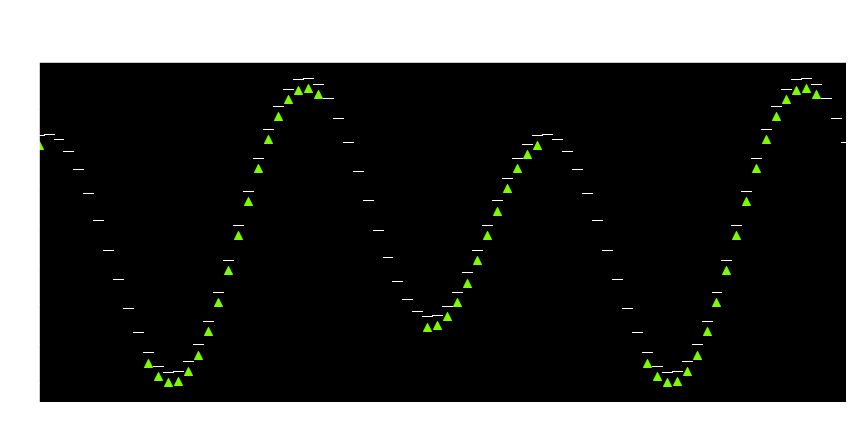

In [8]:
# Running the agent
done = False
state = environment.reset()
while not done:
    action = agent.act(state)
    state, _, done, info = environment.step(action)
    if 'status' in info and info['status'] == 'Closed plot':
        done = True
    else:
        environment.render()